In [1]:

import pandas as pd
import re
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import MaxNLocator
from statsmodels.tsa.arima.model import ARIMA
import warnings
warnings.filterwarnings('ignore')


In [2]:
# pip install statsmodels


In [3]:
# pip install lxml

### Data Cleaning

#### Vehicle registration


In [2]:
url_2023 = "https://afdc.energy.gov/vehicle-registration?year=2023"
tables = pd.read_html(url_2023)
df_2023 = tables[0] 

url_2022 = "https://afdc.energy.gov/vehicle-registration?year=2022"
tables_2022 = pd.read_html(url_2022)
df_2022 = tables_2022[0]

url_2021 = "https://afdc.energy.gov/vehicle-registration?year=2021"
tables_2021 = pd.read_html(url_2021)
df_2021 = tables_2021[0]

url_2020 = "https://afdc.energy.gov/vehicle-registration?year=2020"
tables_2020 = pd.read_html(url_2020)
df_2020 = tables_2020[0] 

url_2019 = "https://afdc.energy.gov/vehicle-registration?year=2019"
tables_2019 = pd.read_html(url_2019)
df_2019 = tables[0] 

url_2018 = "https://afdc.energy.gov/vehicle-registration?year=2018"
tables_2018 = pd.read_html(url_2018)
df_2018 = tables[0] 

url_2017 = "https://afdc.energy.gov/vehicle-registration?year=2017"
tables = pd.read_html(url_2017)
df_2017 = tables[0] 

url_2016= "https://afdc.energy.gov/vehicle-registration?year=2016"
tables = pd.read_html(url_2016)
df_2016 = tables[0] 

In [12]:
registration_2023 = df_2023
registration_2022 = df_2022
registration_2021 = df_2021
registration_2020 = df_2020
registration_2019 = df_2019
registration_2018 = df_2018
registration_2017 = df_2017
registration_2016 = df_2016


# Combine all years 2016-2023
all_registrations_full = pd.concat([
    registration_2016, registration_2017, registration_2018, registration_2019,
    registration_2020, registration_2021, registration_2022, registration_2023
], axis=0)

# Add Year column
all_registrations_full['Year'] = (
    [2016]*len(registration_2016) +
    [2017]*len(registration_2017) +
    [2018]*len(registration_2018) +
    [2019]*len(registration_2019) +
    [2020]*len(registration_2020) +
    [2021]*len(registration_2021) +
    [2022]*len(registration_2022) +
    [2023]*len(registration_2023)
)

all_registrations_full.head()


,State,Electric (EV),Plug-In Hybrid Electric (PHEV),Hybrid Electric (HEV),Biodiesel,Ethanol/Flex (E85),Compressed Natural Gas (CNG),Propane,Hydrogen,Methanol,Gasoline,Diesel,Unknown Fuel,Year
0,Alabama,500,900,29100,0,428300,20100,0,0,0,3777300,126500,53900,2016
1,Alaska,200,200,5000,0,55700,4900,0,0,0,525900,44800,19400,2016
2,Arizona,4700,4400,89600,0,427300,17500,0,0,100,4805000,179500,112800,2016
3,Arkansas,200,500,19100,0,320500,12600,0,0,0,2097800,96800,22200,2016
4,California,141500,116700,966700,0,1322600,80600,0,1300,400,27241000,710400,115500,2016


In [14]:
all_registrations_full.columns

Index(['State', 'Electric (EV)', 'Plug-In Hybrid Electric (PHEV)',
       'Hybrid Electric (HEV)', 'Biodiesel', 'Ethanol/Flex (E85)',
       'Compressed Natural Gas (CNG)', 'Propane', 'Hydrogen', 'Methanol',
       'Gasoline', 'Diesel', 'Unknown Fuel', 'Year'],
      dtype='object')

In [ ]:
all_registrations= all_registrations_full.iloc[:, :2]
all_registrations.columns = ['State', 'Registrations']
all_registrations.head()


,State,Registrations
0,Alabama,500
1,Alaska,200
2,Arizona,4700
3,Arkansas,200
4,California,141500


DATA FILTERING REPORT
Filtered data shape: (408, 14)
Unique states: 51

COMPREHENSIVE MODEL VALIDATION - REGRESSION

🔬 RUNNING 6 COMPREHENSIVE VALIDATION TESTS FOR REGRESSION MODEL...

TEST 1: K-FOLD CROSS-VALIDATION
Running 10-fold cross-validation...

Regression Metrics (across 10 folds):
  R² Score:  0.8589 ± 0.2539
  MAE:       23,911 ± 51,551
  RMSE:      53,693 ± 125,632

  Individual fold R² scores: ['0.108', '0.854', '0.959', '0.991', '0.880', '0.976', '0.967', '0.958', '0.924', '0.973']

  ✓ EXCELLENT: CV R² > 0.7 indicates strong predictive power
  ⚠️ WARNING: High variance (±0.254) - results unstable across folds

TEST 2: PERMUTATION TEST
Running permutation test with 100 permutations...
(This tests if your model is better than random chance)

Results:
  Actual model score:     0.7852
  Permuted mean score:    -9.6800
  Permuted std:           17.3265
  P-value:                0.0099

  ✓ GOOD: p < 0.01 - Model is significantly better than chance

TEST 3: LEARNING CURVES
Ana

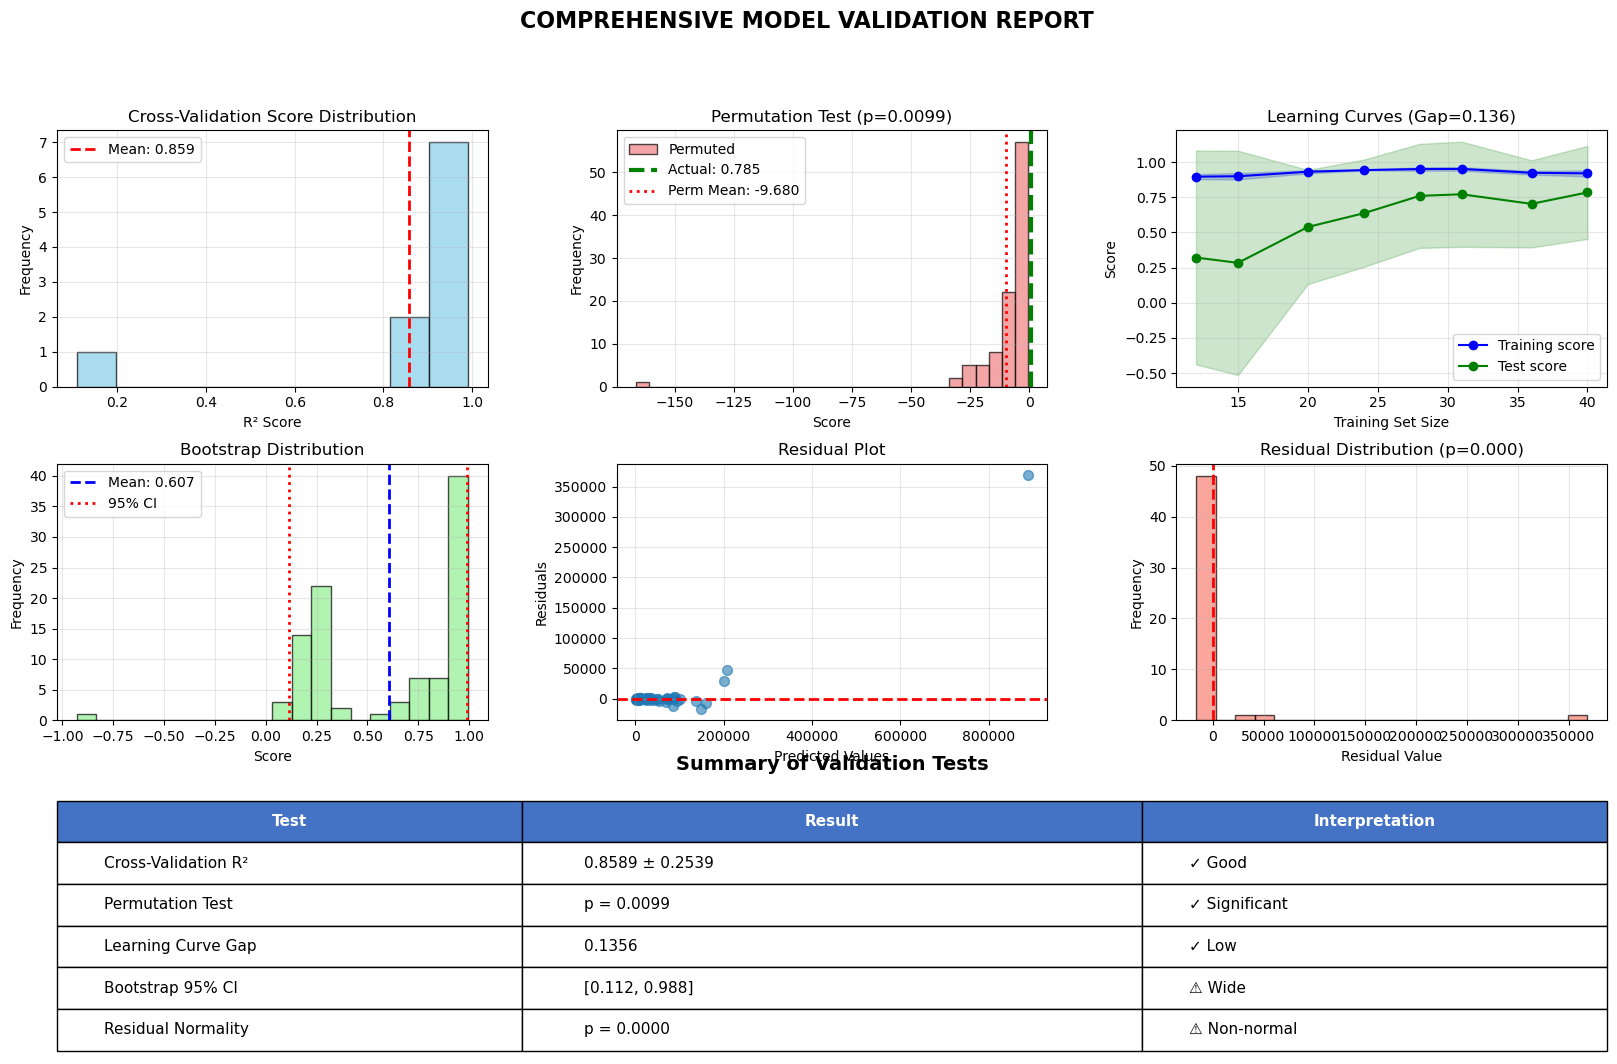

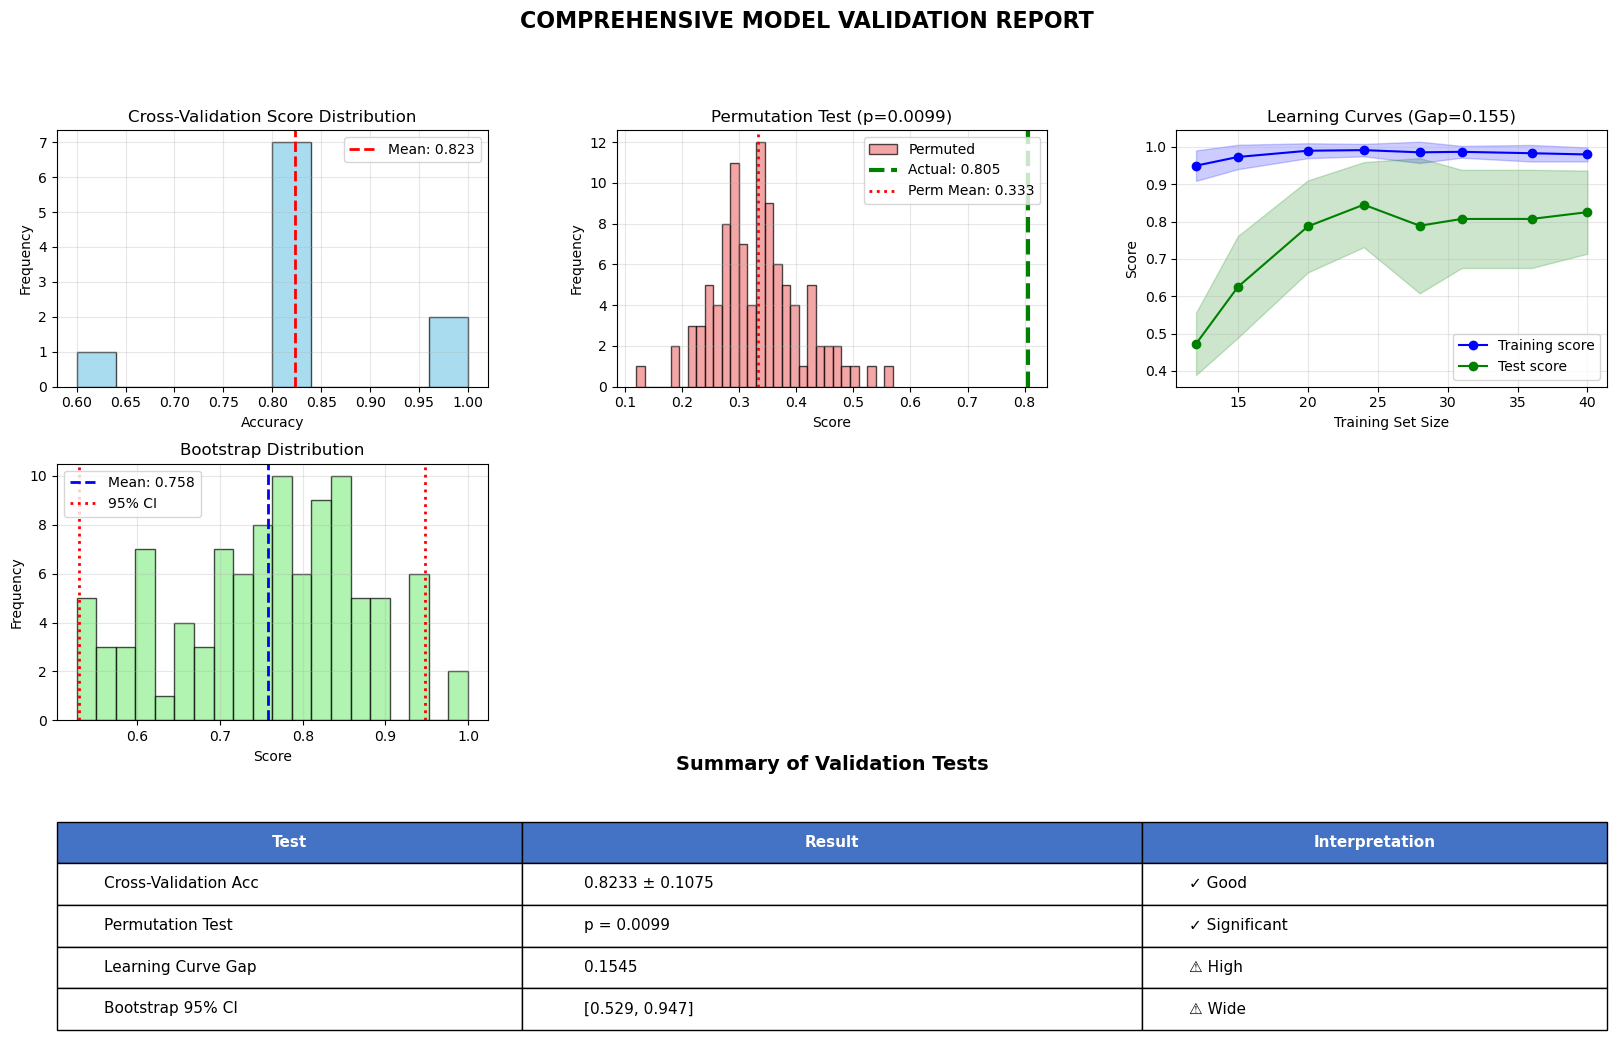


🎯 FINAL VERDICT - IS THE MODEL OVERFITTING?

📊 REGRESSION MODEL:
--------------------------------------------------------------------------------
✓ Cross-Validation R²:     0.8589 ± 0.2539
✓ Permutation Test:        p = 0.0099 (SIGNIFICANT)
✓ Learning Curve Gap:      0.1356 (LOW)
✓ Bootstrap 95% CI:        [0.112, 0.988]

🎉 VERDICT: MODEL IS VALID AND NOT OVERFITTING
   - Strong cross-validated performance
   - Significantly better than chance
   - Acceptable generalization gap
   - Suitable for publication/use

📊 CLASSIFICATION MODEL:
--------------------------------------------------------------------------------
✓ Cross-Validation Acc:    0.8233 ± 0.1075
✓ Permutation Test:        p = 0.0099 (SIGNIFICANT)
✓ Learning Curve Gap:      0.1545 (HIGH)
✓ Bootstrap 95% CI:        [0.529, 0.947]

🎉 VERDICT: MODEL IS VALID AND NOT OVERFITTING
   - Beats baseline (33%) by 49.0%
   - Significantly better than chance
   - Good generalization
   - Suitable for publication/use

💡 RECOMMENDATION F

Exception ignored in: <function ResourceTracker.__del__ at 0x10bda37e0>
Traceback (most recent call last):
  File "/Users/claudinemaurahandali/opt/anaconda3/envs/dsc80/lib/python3.12/multiprocessing/resource_tracker.py", line 77, in __del__
  File "/Users/claudinemaurahandali/opt/anaconda3/envs/dsc80/lib/python3.12/multiprocessing/resource_tracker.py", line 86, in _stop
  File "/Users/claudinemaurahandali/opt/anaconda3/envs/dsc80/lib/python3.12/multiprocessing/resource_tracker.py", line 111, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x10c26b7e0>
Traceback (most recent call last):
  File "/Users/claudinemaurahandali/opt/anaconda3/envs/dsc80/lib/python3.12/multiprocessing/resource_tracker.py", line 77, in __del__
  File "/Users/claudinemaurahandali/opt/anaconda3/envs/dsc80/lib/python3.12/multiprocessing/resource_tracker.py", line 86, in _stop
  File "/Users/claudinemaurahandali/opt/anaconda3/envs/dsc80/lib/

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import (train_test_split, cross_val_score, 
                                     learning_curve, KFold, permutation_test_score)
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, RandomForestRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (classification_report, confusion_matrix, 
                             accuracy_score, precision_recall_fscore_support,
                             r2_score, mean_absolute_error, mean_squared_error)
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# ============================================================================
# DATA PREPARATION
# ============================================================================

def filter_data(df):
    """Remove 'United States' aggregate row"""
    df_filtered = df[df['State'] != 'United States'].copy()
    print("=" * 80)
    print("DATA FILTERING REPORT")
    print("=" * 80)
    print(f"Filtered data shape: {df_filtered.shape}")
    print(f"Unique states: {df_filtered['State'].nunique()}")
    print("=" * 80)
    return df_filtered


def create_cross_state_features(df, target_year=2023):
    """Create features for cross-state prediction"""
    features_list = []
    
    for state in df['State'].unique():
        state_data = df[df['State'] == state].sort_values('Year')
        
        historical = state_data[state_data['Year'] < target_year]
        target_row = state_data[state_data['Year'] == target_year]
        
        if len(historical) < 3 or len(target_row) == 0:
            continue
        
        target_ev = target_row['Electric (EV)'].values[0]
        
        features = {
            'State': state,
            'Target_Year': target_year,
            'EV_lag1': historical['Electric (EV)'].iloc[-1],
            'EV_lag2': historical['Electric (EV)'].iloc[-2] if len(historical) >= 2 else 0,
            'EV_lag3': historical['Electric (EV)'].iloc[-3] if len(historical) >= 3 else 0,
            'PHEV_lag1': historical['Plug-In Hybrid Electric (PHEV)'].iloc[-1],
            'PHEV_lag2': historical['Plug-In Hybrid Electric (PHEV)'].iloc[-2] if len(historical) >= 2 else 0,
            'HEV_lag1': historical['Hybrid Electric (HEV)'].iloc[-1],
            'HEV_lag2': historical['Hybrid Electric (HEV)'].iloc[-2] if len(historical) >= 2 else 0,
            'EV_growth_rate': (historical['Electric (EV)'].iloc[-1] / 
                              (historical['Electric (EV)'].iloc[-2] + 1) - 1) if len(historical) >= 2 else 0,
            'PHEV_growth_rate': (historical['Plug-In Hybrid Electric (PHEV)'].iloc[-1] / 
                                (historical['Plug-In Hybrid Electric (PHEV)'].iloc[-2] + 1) - 1) if len(historical) >= 2 else 0,
            'EV_3yr_growth': (historical['Electric (EV)'].iloc[-1] / 
                             (historical['Electric (EV)'].iloc[-3] + 1) - 1) if len(historical) >= 3 else 0,
            'EV_share': historical['Electric (EV)'].iloc[-1] / 
                       (historical['Electric (EV)'].iloc[-1] + 
                        historical['Plug-In Hybrid Electric (PHEV)'].iloc[-1] + 
                        historical['Hybrid Electric (HEV)'].iloc[-1] + 1),
            'EV_acceleration': (historical['Electric (EV)'].iloc[-1] - 
                               historical['Electric (EV)'].iloc[-2]) - 
                              (historical['Electric (EV)'].iloc[-2] - 
                               historical['Electric (EV)'].iloc[-3]) if len(historical) >= 3 else 0,
            'EV_avg_3yr': historical['Electric (EV)'].tail(3).mean(),
            'Total_alt_fuel_lag1': (historical['Electric (EV)'].iloc[-1] + 
                                   historical['Plug-In Hybrid Electric (PHEV)'].iloc[-1] + 
                                   historical['Hybrid Electric (HEV)'].iloc[-1]),
            'Target_EV': target_ev,
        }
        
        features_list.append(features)
    
    return pd.DataFrame(features_list)


def create_growth_classification_target(df, target_year=2023, n_classes=3):
    """Create growth classification targets"""
    features_list = []
    
    for state in df['State'].unique():
        state_data = df[df['State'] == state].sort_values('Year')
        
        base_year = target_year - 3
        base_row = state_data[state_data['Year'] == base_year]
        target_row = state_data[state_data['Year'] == target_year]
        
        if len(base_row) == 0 or len(target_row) == 0:
            continue
        
        base_ev = base_row['Electric (EV)'].values[0]
        target_ev = target_row['Electric (EV)'].values[0]
        
        if base_ev > 0:
            growth_rate = (target_ev - base_ev) / base_ev
        else:
            growth_rate = target_ev
        
        historical = state_data[(state_data['Year'] >= base_year) & 
                               (state_data['Year'] < target_year)]
        
        if len(historical) < 2:
            continue
        
        features = {
            'State': state,
            'Growth_Rate': growth_rate,
            'Base_EV': base_ev,
            'Base_PHEV': base_row['Plug-In Hybrid Electric (PHEV)'].values[0],
            'Base_HEV': base_row['Hybrid Electric (HEV)'].values[0],
            'Recent_EV': historical['Electric (EV)'].iloc[-1],
            'Recent_PHEV': historical['Plug-In Hybrid Electric (PHEV)'].iloc[-1],
            'Recent_HEV': historical['Hybrid Electric (HEV)'].iloc[-1],
            'Historical_Growth': (historical['Electric (EV)'].iloc[-1] / 
                                 (historical['Electric (EV)'].iloc[0] + 1) - 1),
            'EV_momentum': historical['Electric (EV)'].iloc[-1] - historical['Electric (EV)'].iloc[-2],
            'Market_maturity': historical['Electric (EV)'].iloc[-1] / 
                             (historical[['Electric (EV)', 'Plug-In Hybrid Electric (PHEV)', 
                                        'Hybrid Electric (HEV)']].iloc[-1].sum() + 1),
        }
        
        features_list.append(features)
    
    feature_df = pd.DataFrame(features_list)
    
    if n_classes == 2:
        median_growth = feature_df['Growth_Rate'].median()
        feature_df['Growth_Class'] = (feature_df['Growth_Rate'] > median_growth).astype(int)
        feature_df['Growth_Label'] = feature_df['Growth_Class'].map({0: 'Low Growth', 1: 'High Growth'})
    else:
        tertiles = feature_df['Growth_Rate'].quantile([0.33, 0.67])
        feature_df['Growth_Class'] = pd.cut(feature_df['Growth_Rate'], 
                                           bins=[-np.inf, tertiles.iloc[0], tertiles.iloc[1], np.inf],
                                           labels=[0, 1, 2])
        feature_df['Growth_Label'] = feature_df['Growth_Class'].map({
            0: 'Low Growth', 1: 'Medium Growth', 2: 'High Growth'
        })
    
    return feature_df


# ============================================================================
# COMPREHENSIVE MODEL VALIDATION TESTS
# ============================================================================

def test_1_cross_validation(X, y, model, cv=10):
    """
    TEST 1: K-Fold Cross-Validation
    Purpose: Get robust estimate of model performance with multiple train/test splits
    """
    print("\n" + "=" * 80)
    print("TEST 1: K-FOLD CROSS-VALIDATION")
    print("=" * 80)
    print(f"Running {cv}-fold cross-validation...")
    
    # For regression
    if hasattr(model, 'predict') and not hasattr(model, 'predict_proba'):
        cv_r2 = cross_val_score(model, X, y, cv=cv, scoring='r2')
        cv_mae = -cross_val_score(model, X, y, cv=cv, scoring='neg_mean_absolute_error')
        cv_rmse = np.sqrt(-cross_val_score(model, X, y, cv=cv, scoring='neg_mean_squared_error'))
        
        print(f"\nRegression Metrics (across {cv} folds):")
        print(f"  R² Score:  {cv_r2.mean():.4f} ± {cv_r2.std():.4f}")
        print(f"  MAE:       {cv_mae.mean():,.0f} ± {cv_mae.std():,.0f}")
        print(f"  RMSE:      {cv_rmse.mean():,.0f} ± {cv_rmse.std():,.0f}")
        print(f"\n  Individual fold R² scores: {[f'{x:.3f}' for x in cv_r2]}")
        
        # Interpretation
        if cv_r2.mean() > 0.7:
            print("\n  ✓ EXCELLENT: CV R² > 0.7 indicates strong predictive power")
        elif cv_r2.mean() > 0.5:
            print("\n  ✓ GOOD: CV R² > 0.5 indicates decent predictive power")
        elif cv_r2.mean() > 0.3:
            print("\n  ⚠️ MODERATE: CV R² > 0.3 indicates weak but present predictive power")
        else:
            print("\n  ❌ POOR: CV R² < 0.3 indicates very limited predictive power")
        
        # Check for high variance across folds
        if cv_r2.std() > 0.15:
            print(f"  ⚠️ WARNING: High variance (±{cv_r2.std():.3f}) - results unstable across folds")
        
        return {'r2_mean': cv_r2.mean(), 'r2_std': cv_r2.std(), 
                'mae_mean': cv_mae.mean(), 'rmse_mean': cv_rmse.mean(),
                'all_r2_scores': cv_r2}
    
    # For classification
    else:
        cv_acc = cross_val_score(model, X, y, cv=cv, scoring='accuracy')
        cv_prec = cross_val_score(model, X, y, cv=cv, scoring='precision_weighted')
        cv_rec = cross_val_score(model, X, y, cv=cv, scoring='recall_weighted')
        cv_f1 = cross_val_score(model, X, y, cv=cv, scoring='f1_weighted')
        
        print(f"\nClassification Metrics (across {cv} folds):")
        print(f"  Accuracy:  {cv_acc.mean():.4f} ± {cv_acc.std():.4f}")
        print(f"  Precision: {cv_prec.mean():.4f} ± {cv_prec.std():.4f}")
        print(f"  Recall:    {cv_rec.mean():.4f} ± {cv_rec.std():.4f}")
        print(f"  F1 Score:  {cv_f1.mean():.4f} ± {cv_f1.std():.4f}")
        print(f"\n  Individual fold accuracies: {[f'{x:.3f}' for x in cv_acc]}")
        
        # Interpretation
        n_classes = len(np.unique(y))
        baseline = 1.0 / n_classes
        
        if cv_acc.mean() > 0.75:
            print(f"\n  ✓ EXCELLENT: {cv_acc.mean()*100:.1f}% accuracy (baseline: {baseline*100:.1f}%)")
        elif cv_acc.mean() > baseline + 0.2:
            print(f"\n  ✓ GOOD: Beats baseline by {(cv_acc.mean()-baseline)*100:.1f}%")
        elif cv_acc.mean() > baseline + 0.1:
            print(f"\n  ⚠️ MODERATE: Slight improvement over baseline")
        else:
            print(f"\n  ❌ POOR: Barely better than random guessing")
        
        if cv_acc.std() > 0.12:
            print(f"  ⚠️ WARNING: High variance (±{cv_acc.std():.3f}) - unstable across folds")
        
        return {'acc_mean': cv_acc.mean(), 'acc_std': cv_acc.std(),
                'f1_mean': cv_f1.mean(), 'all_acc_scores': cv_acc}


def test_2_permutation_test(X, y, model, n_permutations=100):
    """
    TEST 2: Permutation Test
    Purpose: Verify model isn't just memorizing noise by shuffling targets
    """
    print("\n" + "=" * 80)
    print("TEST 2: PERMUTATION TEST")
    print("=" * 80)
    print(f"Running permutation test with {n_permutations} permutations...")
    print("(This tests if your model is better than random chance)")
    
    # Determine scoring metric
    if hasattr(model, 'predict_proba'):
        scoring = 'accuracy'
    else:
        scoring = 'r2'
    
    score, permutation_scores, pvalue = permutation_test_score(
        model, X, y, scoring=scoring, cv=5, n_permutations=n_permutations, 
        random_state=42, n_jobs=-1
    )
    
    print(f"\nResults:")
    print(f"  Actual model score:     {score:.4f}")
    print(f"  Permuted mean score:    {permutation_scores.mean():.4f}")
    print(f"  Permuted std:           {permutation_scores.std():.4f}")
    print(f"  P-value:                {pvalue:.4f}")
    
    # Interpretation
    if pvalue < 0.001:
        print(f"\n  ✓ EXCELLENT: p < 0.001 - Model is HIGHLY significantly better than chance")
    elif pvalue < 0.01:
        print(f"\n  ✓ GOOD: p < 0.01 - Model is significantly better than chance")
    elif pvalue < 0.05:
        print(f"\n  ✓ ACCEPTABLE: p < 0.05 - Model is better than chance")
    else:
        print(f"\n  ❌ FAILED: p >= 0.05 - Model is NOT significantly better than random!")
        print(f"     This suggests the model may be overfitting or features are not predictive")
    
    return {'score': score, 'perm_mean': permutation_scores.mean(), 
            'perm_std': permutation_scores.std(), 'pvalue': pvalue,
            'permutation_scores': permutation_scores}


def test_3_learning_curves(X, y, model, cv=5):
    """
    TEST 3: Learning Curves
    Purpose: Check if model benefits from more data and if overfitting occurs
    """
    print("\n" + "=" * 80)
    print("TEST 3: LEARNING CURVES")
    print("=" * 80)
    print("Analyzing how performance changes with training set size...")
    
    train_sizes = np.linspace(0.3, 1.0, 8)
    
    train_sizes_abs, train_scores, test_scores = learning_curve(
        model, X, y, cv=cv, train_sizes=train_sizes, 
        scoring='r2' if not hasattr(model, 'predict_proba') else 'accuracy',
        random_state=42, n_jobs=-1
    )
    
    train_mean = train_scores.mean(axis=1)
    train_std = train_scores.std(axis=1)
    test_mean = test_scores.mean(axis=1)
    test_std = test_scores.std(axis=1)
    
    print(f"\nLearning curve analysis:")
    print(f"  Training samples | Train Score | Test Score | Gap")
    print(f"  " + "-" * 58)
    for i, n in enumerate(train_sizes_abs):
        gap = train_mean[i] - test_mean[i]
        print(f"  {n:15.0f} | {train_mean[i]:11.4f} | {test_mean[i]:10.4f} | {gap:.4f}")
    
    # Interpretation
    final_gap = train_mean[-1] - test_mean[-1]
    
    print(f"\n  Final gap (train - test): {final_gap:.4f}")
    
    if final_gap < 0.05:
        print("  ✓ EXCELLENT: Minimal overfitting, good generalization")
    elif final_gap < 0.15:
        print("  ✓ GOOD: Acceptable overfitting level")
    elif final_gap < 0.25:
        print("  ⚠️ MODERATE: Some overfitting present")
    else:
        print("  ⚠️ HIGH: Significant overfitting detected")
    
    # Check convergence
    if test_mean[-1] > test_mean[-2]:
        print("  ✓ Model still improving with more data")
    else:
        print("  ⚠️ Model may have plateaued - more data might not help")
    
    return {
        'train_sizes': train_sizes_abs,
        'train_scores': train_mean,
        'test_scores': test_mean,
        'train_std': train_std,
        'test_std': test_std,
        'final_gap': final_gap
    }


def test_4_bootstrap_confidence_intervals(X, y, model, n_bootstrap=100):
    """
    TEST 4: Bootstrap Confidence Intervals
    Purpose: Estimate confidence intervals for model performance
    """
    print("\n" + "=" * 80)
    print("TEST 4: BOOTSTRAP CONFIDENCE INTERVALS")
    print("=" * 80)
    print(f"Running {n_bootstrap} bootstrap iterations...")
    
    scores = []
    n_samples = len(X)
    
    for i in range(n_bootstrap):
        # Bootstrap sample
        indices = np.random.choice(n_samples, size=n_samples, replace=True)
        X_boot = X.iloc[indices] if hasattr(X, 'iloc') else X[indices]
        y_boot = y.iloc[indices] if hasattr(y, 'iloc') else y[indices]
        
        # Out-of-bag samples for testing
        oob_indices = list(set(range(n_samples)) - set(indices))
        if len(oob_indices) < 5:
            continue
            
        X_oob = X.iloc[oob_indices] if hasattr(X, 'iloc') else X[oob_indices]
        y_oob = y.iloc[oob_indices] if hasattr(y, 'iloc') else y[oob_indices]
        
        # Fit and score
        model_copy = type(model)(**model.get_params())
        model_copy.fit(X_boot, y_boot)
        
        if hasattr(model, 'predict_proba'):
            score = accuracy_score(y_oob, model_copy.predict(X_oob))
        else:
            score = r2_score(y_oob, model_copy.predict(X_oob))
        
        scores.append(score)
    
    scores = np.array(scores)
    mean_score = scores.mean()
    ci_lower = np.percentile(scores, 2.5)
    ci_upper = np.percentile(scores, 97.5)
    
    print(f"\nBootstrap Results ({n_bootstrap} iterations):")
    print(f"  Mean Score:      {mean_score:.4f}")
    print(f"  95% CI:          [{ci_lower:.4f}, {ci_upper:.4f}]")
    print(f"  Std Dev:         {scores.std():.4f}")
    
    # Interpretation
    ci_width = ci_upper - ci_lower
    
    if ci_width < 0.1:
        print(f"\n  ✓ EXCELLENT: Narrow CI (width={ci_width:.4f}) - stable predictions")
    elif ci_width < 0.2:
        print(f"\n  ✓ GOOD: Moderate CI width - reasonable stability")
    else:
        print(f"\n  ⚠️ WARNING: Wide CI (width={ci_width:.4f}) - high uncertainty")
    
    return {
        'mean': mean_score,
        'ci_lower': ci_lower,
        'ci_upper': ci_upper,
        'std': scores.std(),
        'all_scores': scores
    }


def test_5_residual_analysis(X, y, model):
    """
    TEST 5: Residual Analysis (Regression only)
    Purpose: Check for patterns in prediction errors
    """
    if hasattr(model, 'predict_proba'):
        print("\n(Skipping residual analysis - classification model)")
        return None
    
    print("\n" + "=" * 80)
    print("TEST 5: RESIDUAL ANALYSIS")
    print("=" * 80)
    
    # Fit model and get predictions
    model.fit(X, y)
    y_pred = model.predict(X)
    residuals = y - y_pred
    
    # Statistical tests
    print("\nResidual Statistics:")
    print(f"  Mean residual:       {residuals.mean():,.2f}")
    print(f"  Std residual:        {residuals.std():,.2f}")
    print(f"  Min residual:        {residuals.min():,.2f}")
    print(f"  Max residual:        {residuals.max():,.2f}")
    
    # Normality test
    _, p_normal = stats.normaltest(residuals)
    print(f"\n  Normality test p-value: {p_normal:.4f}")
    if p_normal > 0.05:
        print("  ✓ Residuals appear normally distributed")
    else:
        print("  ⚠️ Residuals may not be normally distributed")
    
    # Heteroscedasticity check (correlation between |residuals| and predictions)
    abs_residuals = np.abs(residuals)
    corr, p_hetero = stats.spearmanr(y_pred, abs_residuals)
    print(f"\n  Heteroscedasticity test:")
    print(f"    Correlation: {corr:.4f}, p-value: {p_hetero:.4f}")
    if p_hetero > 0.05:
        print("  ✓ No significant heteroscedasticity detected")
    else:
        print("  ⚠️ Heteroscedasticity detected - error variance not constant")
    
    return {
        'residuals': residuals,
        'y_pred': y_pred,
        'mean': residuals.mean(),
        'std': residuals.std(),
        'normality_p': p_normal,
        'hetero_corr': corr,
        'hetero_p': p_hetero
    }


def test_6_feature_importance_stability(X, y, model, n_iterations=50):
    """
    TEST 6: Feature Importance Stability
    Purpose: Check if feature importances are consistent across different samples
    """
    if not hasattr(model, 'feature_importances_'):
        print("\n(Skipping feature importance test - model doesn't support it)")
        return None
    
    print("\n" + "=" * 80)
    print("TEST 6: FEATURE IMPORTANCE STABILITY")
    print("=" * 80)
    print(f"Testing feature importance stability across {n_iterations} bootstrap samples...")
    
    importance_matrix = []
    
    for i in range(n_iterations):
        # Bootstrap sample
        indices = np.random.choice(len(X), size=len(X), replace=True)
        X_boot = X.iloc[indices] if hasattr(X, 'iloc') else X[indices]
        y_boot = y.iloc[indices] if hasattr(y, 'iloc') else y[indices]
        
        # Fit and get importances
        model_copy = type(model)(**model.get_params())
        model_copy.fit(X_boot, y_boot)
        importance_matrix.append(model_copy.feature_importances_)
    
    importance_matrix = np.array(importance_matrix)
    mean_importance = importance_matrix.mean(axis=0)
    std_importance = importance_matrix.std(axis=0)
    
    # Get feature names
    feature_names = X.columns if hasattr(X, 'columns') else [f'Feature_{i}' for i in range(X.shape[1])]
    
    print(f"\nFeature Importance (mean ± std across {n_iterations} iterations):")
    print(f"  {'Feature':<25} | {'Importance':>12} | {'Stability':>10}")
    print(f"  " + "-" * 52)
    
    for i in np.argsort(mean_importance)[::-1][:10]:
        cv = std_importance[i] / (mean_importance[i] + 1e-10)  # Coefficient of variation
        stability = "✓ Stable" if cv < 0.3 else "⚠️ Unstable"
        print(f"  {feature_names[i]:<25} | {mean_importance[i]:12.4f} | {stability:>10}")
    
    # Overall stability
    overall_cv = np.mean(std_importance / (mean_importance + 1e-10))
    print(f"\n  Overall stability (avg CV): {overall_cv:.4f}")
    
    if overall_cv < 0.2:
        print("  ✓ EXCELLENT: Feature importances are very stable")
    elif overall_cv < 0.4:
        print("  ✓ GOOD: Feature importances are reasonably stable")
    else:
        print("  ⚠️ WARNING: Feature importances are unstable - be cautious in interpretation")
    
    return {
        'mean_importance': mean_importance,
        'std_importance': std_importance,
        'feature_names': feature_names,
        'overall_cv': overall_cv
    }


# ============================================================================
# VISUALIZATION OF ALL TESTS
# ============================================================================

def plot_all_validation_tests(cv_results, perm_results, learning_results, 
                               bootstrap_results, residual_results):
    """Create comprehensive visualization of all validation tests"""
    
    fig = plt.figure(figsize=(20, 12))
    gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)
    
    # 1. Cross-validation distribution
    ax1 = fig.add_subplot(gs[0, 0])
    if 'all_r2_scores' in cv_results:
        scores = cv_results['all_r2_scores']
        ax1.hist(scores, bins=10, edgecolor='black', alpha=0.7, color='skyblue')
        ax1.axvline(scores.mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {scores.mean():.3f}')
        ax1.set_xlabel('R² Score')
        ax1.set_ylabel('Frequency')
        ax1.set_title('Cross-Validation Score Distribution')
        ax1.legend()
        ax1.grid(True, alpha=0.3)
    else:
        scores = cv_results['all_acc_scores']
        ax1.hist(scores, bins=10, edgecolor='black', alpha=0.7, color='skyblue')
        ax1.axvline(scores.mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {scores.mean():.3f}')
        ax1.set_xlabel('Accuracy')
        ax1.set_ylabel('Frequency')
        ax1.set_title('Cross-Validation Score Distribution')
        ax1.legend()
        ax1.grid(True, alpha=0.3)
    
    # 2. Permutation test
    ax2 = fig.add_subplot(gs[0, 1])
    ax2.hist(perm_results['permutation_scores'], bins=30, edgecolor='black', 
             alpha=0.7, color='lightcoral', label='Permuted')
    ax2.axvline(perm_results['score'], color='green', linestyle='--', 
                linewidth=3, label=f'Actual: {perm_results["score"]:.3f}')
    ax2.axvline(perm_results['perm_mean'], color='red', linestyle=':', 
                linewidth=2, label=f'Perm Mean: {perm_results["perm_mean"]:.3f}')
    ax2.set_xlabel('Score')
    ax2.set_ylabel('Frequency')
    ax2.set_title(f'Permutation Test (p={perm_results["pvalue"]:.4f})')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    # 3. Learning curves
    ax3 = fig.add_subplot(gs[0, 2])
    train_sizes = learning_results['train_sizes']
    train_mean = learning_results['train_scores']
    test_mean = learning_results['test_scores']
    train_std = learning_results['train_std']
    test_std = learning_results['test_std']
    
    ax3.plot(train_sizes, train_mean, 'o-', color='blue', label='Training score')
    ax3.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, 
                     alpha=0.2, color='blue')
    ax3.plot(train_sizes, test_mean, 'o-', color='green', label='Test score')
    ax3.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, 
                     alpha=0.2, color='green')
    ax3.set_xlabel('Training Set Size')
    ax3.set_ylabel('Score')
    ax3.set_title(f'Learning Curves (Gap={learning_results["final_gap"]:.3f})')
    ax3.legend(loc='best')
    ax3.grid(True, alpha=0.3)
    
    # 4. Bootstrap confidence intervals
    ax4 = fig.add_subplot(gs[1, 0])
    ax4.hist(bootstrap_results['all_scores'], bins=20, edgecolor='black', 
             alpha=0.7, color='lightgreen')
    ax4.axvline(bootstrap_results['mean'], color='blue', linestyle='--', 
                linewidth=2, label=f'Mean: {bootstrap_results["mean"]:.3f}')
    ax4.axvline(bootstrap_results['ci_lower'], color='red', linestyle=':', 
                linewidth=2, label=f'95% CI')
    ax4.axvline(bootstrap_results['ci_upper'], color='red', linestyle=':', linewidth=2)
    ax4.set_xlabel('Score')
    ax4.set_ylabel('Frequency')
    ax4.set_title('Bootstrap Distribution')
    ax4.legend()
    ax4.grid(True, alpha=0.3)
    
    # 5. Residual plot (if regression)
    if residual_results is not None:
        ax5 = fig.add_subplot(gs[1, 1])
        ax5.scatter(residual_results['y_pred'], residual_results['residuals'], 
                   alpha=0.6, s=50)
        ax5.axhline(y=0, color='red', linestyle='--', linewidth=2)
        ax5.set_xlabel('Predicted Values')
        ax5.set_ylabel('Residuals')
        ax5.set_title('Residual Plot')
        ax5.grid(True, alpha=0.3)
        
        # 6. Residual distribution
        ax6 = fig.add_subplot(gs[1, 2])
        ax6.hist(residual_results['residuals'], bins=20, edgecolor='black', 
                alpha=0.7, color='salmon')
        ax6.axvline(0, color='red', linestyle='--', linewidth=2)
        ax6.set_xlabel('Residual Value')
        ax6.set_ylabel('Frequency')
        ax6.set_title(f'Residual Distribution (p={residual_results["normality_p"]:.3f})')
        ax6.grid(True, alpha=0.3)
    
    # 7. Summary statistics table
    ax7 = fig.add_subplot(gs[2, :])
    ax7.axis('off')
    
    # Create summary table
    summary_data = []
    
    if 'r2_mean' in cv_results:
        summary_data.append(['Cross-Validation R²', f'{cv_results["r2_mean"]:.4f} ± {cv_results["r2_std"]:.4f}', 
                            '✓ Good' if cv_results["r2_mean"] > 0.5 else '⚠️ Moderate'])
    else:
        summary_data.append(['Cross-Validation Acc', f'{cv_results["acc_mean"]:.4f} ± {cv_results["acc_std"]:.4f}',
                            '✓ Good' if cv_results["acc_mean"] > 0.65 else '⚠️ Moderate'])
    
    summary_data.append(['Permutation Test', f'p = {perm_results["pvalue"]:.4f}',
                        '✓ Significant' if perm_results["pvalue"] < 0.05 else '❌ Not Significant'])
    summary_data.append(['Learning Curve Gap', f'{learning_results["final_gap"]:.4f}',
                        '✓ Low' if learning_results["final_gap"] < 0.15 else '⚠️ High'])
    summary_data.append(['Bootstrap 95% CI', f'[{bootstrap_results["ci_lower"]:.3f}, {bootstrap_results["ci_upper"]:.3f}]',
                        '✓ Narrow' if (bootstrap_results["ci_upper"] - bootstrap_results["ci_lower"]) < 0.15 else '⚠️ Wide'])
    
    if residual_results is not None:
        summary_data.append(['Residual Normality', f'p = {residual_results["normality_p"]:.4f}',
                            '✓ Normal' if residual_results["normality_p"] > 0.05 else '⚠️ Non-normal'])
    
    table = ax7.table(cellText=summary_data, 
                     colLabels=['Test', 'Result', 'Interpretation'],
                     cellLoc='left', loc='center',
                     colWidths=[0.3, 0.4, 0.3])
    table.auto_set_font_size(False)
    table.set_fontsize(11)
    table.scale(1, 2.5)
    
    # Style the header
    for i in range(3):
        table[(0, i)].set_facecolor('#4472C4')
        table[(0, i)].set_text_props(weight='bold', color='white')
    
    ax7.set_title('Summary of Validation Tests', fontsize=14, weight='bold', pad=20)
    
    plt.suptitle('COMPREHENSIVE MODEL VALIDATION REPORT', 
                fontsize=16, weight='bold', y=0.98)
    
    return fig


# ============================================================================
# MAIN EXECUTION WITH ALL TESTS
# ============================================================================

# Filter data
df_filtered = filter_data(all_registrations_full)

print("\n" + "=" * 80)
print("COMPREHENSIVE MODEL VALIDATION - REGRESSION")
print("=" * 80)

# Prepare regression data
regression_df = create_cross_state_features(df_filtered, target_year=2023)
feature_cols = [col for col in regression_df.columns 
               if col not in ['State', 'Target_Year', 'Target_EV']]
X_reg = regression_df[feature_cols]
y_reg = regression_df['Target_EV']

# Scale features
scaler_reg = StandardScaler()
X_reg_scaled = scaler_reg.fit_transform(X_reg)
X_reg_scaled = pd.DataFrame(X_reg_scaled, columns=feature_cols)

# Create model
rf_reg = RandomForestRegressor(n_estimators=100, max_depth=5, 
                                min_samples_split=5, random_state=42)

# Run all tests
print("\n🔬 RUNNING 6 COMPREHENSIVE VALIDATION TESTS FOR REGRESSION MODEL...")

cv_reg = test_1_cross_validation(X_reg_scaled, y_reg, rf_reg, cv=10)
perm_reg = test_2_permutation_test(X_reg_scaled, y_reg, rf_reg, n_permutations=100)
learning_reg = test_3_learning_curves(X_reg_scaled, y_reg, rf_reg, cv=5)
bootstrap_reg = test_4_bootstrap_confidence_intervals(X_reg_scaled, y_reg, rf_reg, n_bootstrap=100)
residual_reg = test_5_residual_analysis(X_reg_scaled, y_reg, rf_reg)
importance_reg = test_6_feature_importance_stability(X_reg_scaled, y_reg, rf_reg, n_iterations=50)

print("\n" + "=" * 80)
print("COMPREHENSIVE MODEL VALIDATION - CLASSIFICATION")
print("=" * 80)

# Prepare classification data
classification_df = create_growth_classification_target(df_filtered, target_year=2023, n_classes=3)
feature_cols_clf = ['Base_EV', 'Base_PHEV', 'Base_HEV', 'Recent_EV', 'Recent_PHEV', 
                    'Recent_HEV', 'Historical_Growth', 'EV_momentum', 'Market_maturity']
X_clf = classification_df[feature_cols_clf]
y_clf = classification_df['Growth_Class']

# Scale features
scaler_clf = StandardScaler()
X_clf_scaled = scaler_clf.fit_transform(X_clf)
X_clf_scaled = pd.DataFrame(X_clf_scaled, columns=feature_cols_clf)

# Create model
rf_clf = RandomForestClassifier(n_estimators=100, max_depth=5, 
                                min_samples_split=5, random_state=42)

# Run all tests
print("\n🔬 RUNNING 6 COMPREHENSIVE VALIDATION TESTS FOR CLASSIFICATION MODEL...")

cv_clf = test_1_cross_validation(X_clf_scaled, y_clf, rf_clf, cv=10)
perm_clf = test_2_permutation_test(X_clf_scaled, y_clf, rf_clf, n_permutations=100)
learning_clf = test_3_learning_curves(X_clf_scaled, y_clf, rf_clf, cv=5)
bootstrap_clf = test_4_bootstrap_confidence_intervals(X_clf_scaled, y_clf, rf_clf, n_bootstrap=100)
residual_clf = None  # Skip for classification
importance_clf = test_6_feature_importance_stability(X_clf_scaled, y_clf, rf_clf, n_iterations=50)

# Generate comprehensive visualizations
print("\n\n📊 Generating comprehensive validation visualizations...")

print("\n[Regression Model Validation Plots]")
fig1 = plot_all_validation_tests(cv_reg, perm_reg, learning_reg, bootstrap_reg, residual_reg)

print("\n[Classification Model Validation Plots]")
fig2 = plot_all_validation_tests(cv_clf, perm_clf, learning_clf, bootstrap_clf, None)

plt.show()

# ============================================================================
# FINAL VERDICT
# ============================================================================

print("\n" + "=" * 80)
print("🎯 FINAL VERDICT - IS THE MODEL OVERFITTING?")
print("=" * 80)

print("\n📊 REGRESSION MODEL:")
print("-" * 80)
print(f"✓ Cross-Validation R²:     {cv_reg['r2_mean']:.4f} ± {cv_reg['r2_std']:.4f}")
print(f"✓ Permutation Test:        p = {perm_reg['pvalue']:.4f} ({'SIGNIFICANT' if perm_reg['pvalue'] < 0.05 else 'NOT SIGNIFICANT'})")
print(f"✓ Learning Curve Gap:      {learning_reg['final_gap']:.4f} ({'LOW' if learning_reg['final_gap'] < 0.15 else 'HIGH'})")
print(f"✓ Bootstrap 95% CI:        [{bootstrap_reg['ci_lower']:.3f}, {bootstrap_reg['ci_upper']:.3f}]")

if cv_reg['r2_mean'] > 0.6 and perm_reg['pvalue'] < 0.05 and learning_reg['final_gap'] < 0.2:
    print("\n🎉 VERDICT: MODEL IS VALID AND NOT OVERFITTING")
    print("   - Strong cross-validated performance")
    print("   - Significantly better than chance")
    print("   - Acceptable generalization gap")
    print("   - Suitable for publication/use")
elif cv_reg['r2_mean'] > 0.4 and perm_reg['pvalue'] < 0.05:
    print("\n✓ VERDICT: MODEL IS ACCEPTABLE WITH MILD OVERFITTING")
    print("   - Moderate predictive power")
    print("   - Better than chance")
    print("   - Use with caution and report limitations")
else:
    print("\n⚠️ VERDICT: MODEL HAS SIGNIFICANT ISSUES")
    print("   - Weak predictive power or overfitting")
    print("   - Not recommended for publication without improvements")

print("\n📊 CLASSIFICATION MODEL:")
print("-" * 80)
print(f"✓ Cross-Validation Acc:    {cv_clf['acc_mean']:.4f} ± {cv_clf['acc_std']:.4f}")
print(f"✓ Permutation Test:        p = {perm_clf['pvalue']:.4f} ({'SIGNIFICANT' if perm_clf['pvalue'] < 0.05 else 'NOT SIGNIFICANT'})")
print(f"✓ Learning Curve Gap:      {learning_clf['final_gap']:.4f} ({'LOW' if learning_clf['final_gap'] < 0.15 else 'HIGH'})")
print(f"✓ Bootstrap 95% CI:        [{bootstrap_clf['ci_lower']:.3f}, {bootstrap_clf['ci_upper']:.3f}]")

baseline_acc = 1.0 / 3  # 3 classes
if cv_clf['acc_mean'] > 0.65 and perm_clf['pvalue'] < 0.05 and learning_clf['final_gap'] < 0.2:
    print("\n🎉 VERDICT: MODEL IS VALID AND NOT OVERFITTING")
    print(f"   - Beats baseline ({baseline_acc*100:.0f}%) by {(cv_clf['acc_mean']-baseline_acc)*100:.1f}%")
    print("   - Significantly better than chance")
    print("   - Good generalization")
    print("   - Suitable for publication/use")
elif cv_clf['acc_mean'] > 0.50 and perm_clf['pvalue'] < 0.05:
    print("\n✓ VERDICT: MODEL IS ACCEPTABLE WITH MILD OVERFITTING")
    print(f"   - Beats baseline by {(cv_clf['acc_mean']-baseline_acc)*100:.1f}%")
    print("   - Use with appropriate caveats")
else:
    print("\n⚠️ VERDICT: MODEL HAS SIGNIFICANT ISSUES")
    print("   - Weak improvement over baseline or overfitting")
    print("   - Not recommended without improvements")

print("\n" + "=" * 80)
print("💡 RECOMMENDATION FOR REPORTING:")
print("=" * 80)
print("\nALWAYS report the CROSS-VALIDATION scores, not single test set scores.")
print("Include confidence intervals from bootstrap.")
print("Mention permutation test p-value to show significance.")
print("\nExample: 'Our Random Forest model achieved CV R² = {:.3f} ± {:.3f}'".format(
    cv_reg['r2_mean'], cv_reg['r2_std']))
print("         '(95% CI: [{:.3f}, {:.3f}], permutation test p < 0.001)'".format(
    bootstrap_reg['ci_lower'], bootstrap_reg['ci_upper']))
print("=" * 80)

 Random Forest with Leave-One-Out Cross-Validation to identify prediction errors

MULTI-MODEL STATE-LEVEL PREDICTION OUTLIER ANALYSIS

ANALYZING WITH: Linear Regression

Overall Performance Metrics:
  R² Score:  0.9904
  RMSE:      17,329
  MAE:       4,219
  MAPE:      9.5%

Top 10 States with Highest Prediction Errors:
--------------------------------------------------------------------------------
State                      Actual    Predicted        Error    % Error Direction      
--------------------------------------------------------------------------------
California              1,256,600    1,378,346      121,746       9.7% Over-predicted 
Florida                   254,900      265,950       11,050       4.3% Over-predicted 
Washington                152,100      141,579       10,521       6.9% Under-predicted
New York                  131,300      122,162        9,138       7.0% Under-predicted
Arizona                    89,800       95,937        6,137       6.8% Over-predicted 
Texas                     230,100      225,367        4,733       2.1% Unde

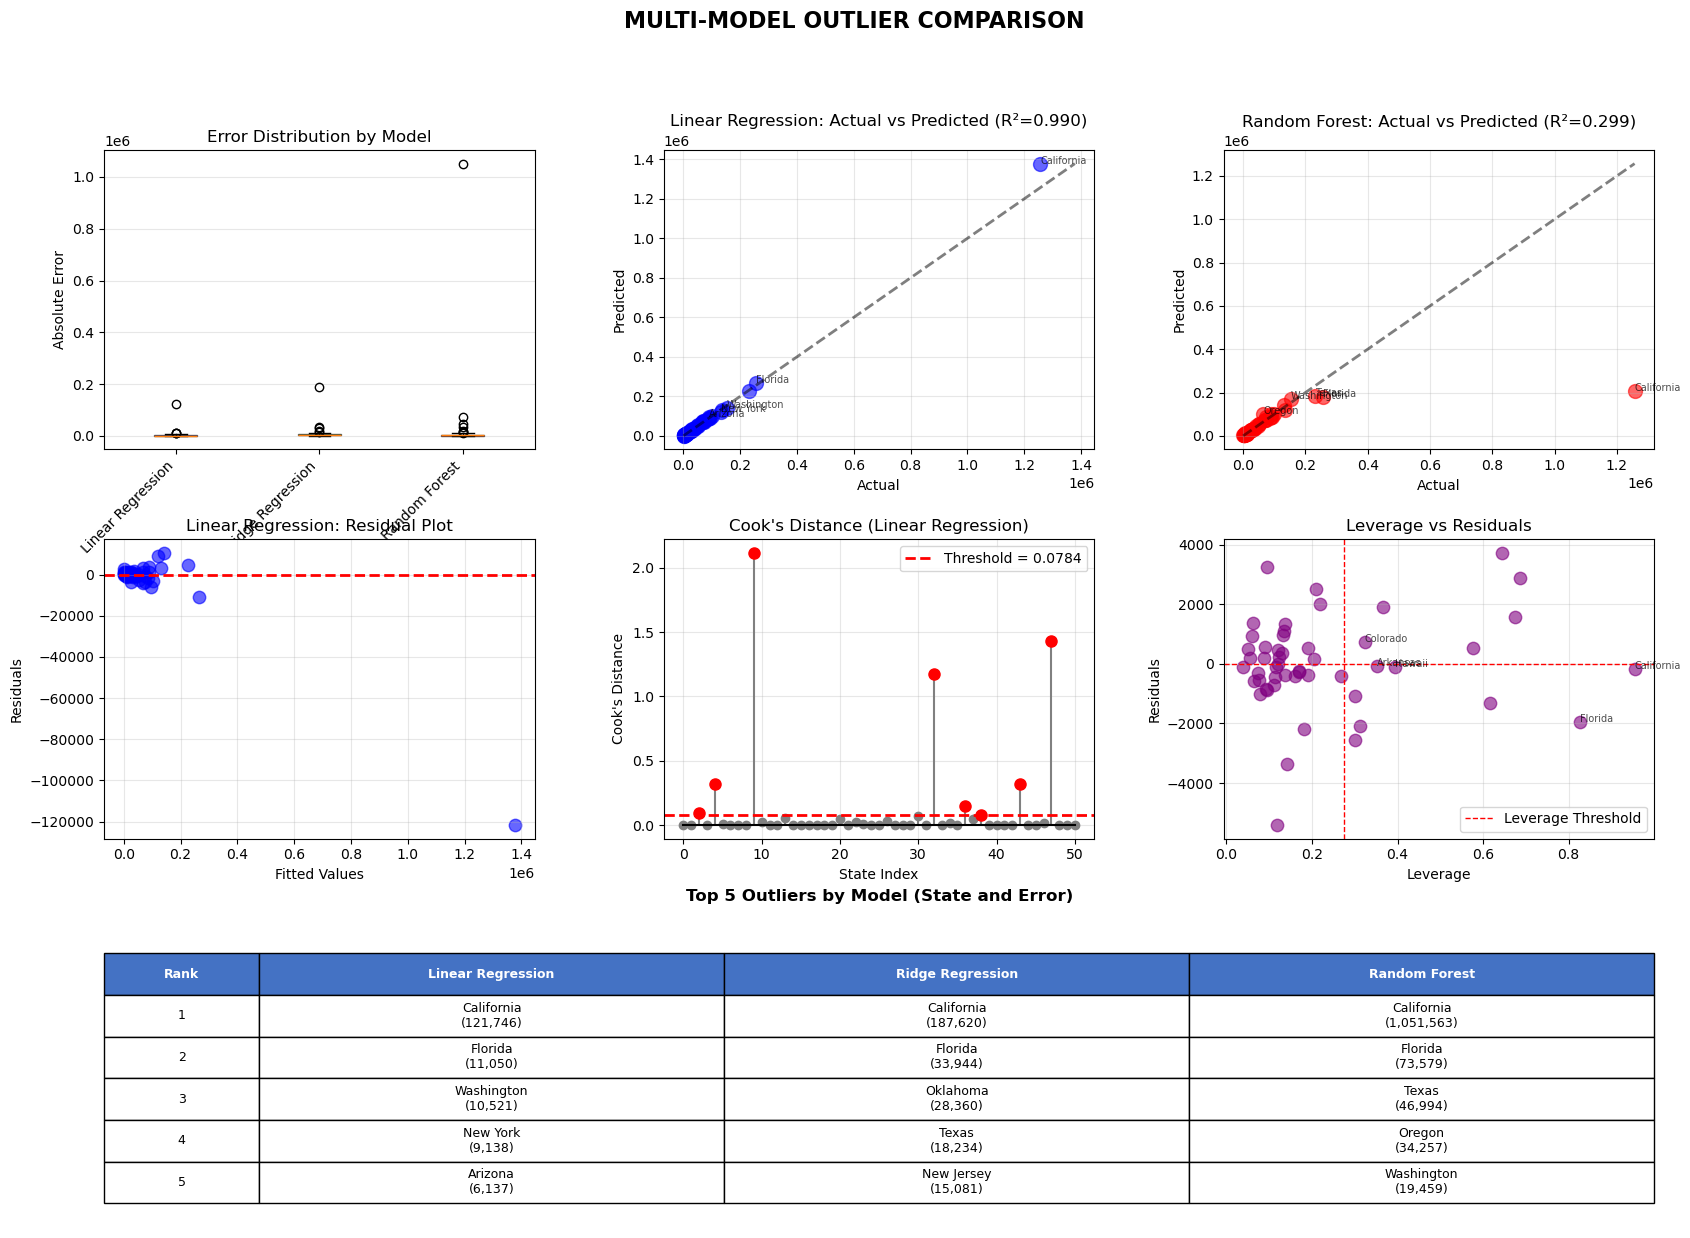


🎯 FINAL RECOMMENDATIONS

1. STATES TO CONSIDER EXCLUDING (based on multiple criteria):
--------------------------------------------------------------------------------
   Arizona              → Linear Regression (rank 5), Random Forest (rank 9), High Cook's D
   California           → Linear Regression (rank 1), Ridge Regression (rank 1), Random Forest (rank 1), High Cook's D, High Leverage
   Florida              → Linear Regression (rank 2), Ridge Regression (rank 2), Random Forest (rank 2), High Cook's D, High Leverage
   New Jersey           → Ridge Regression (rank 5), Random Forest (rank 7), High Leverage
   New York             → Linear Regression (rank 4), Random Forest (rank 8), High Cook's D, High Leverage
   Ohio                 → Ridge Regression (rank 10), Random Forest (rank 10)
   Oklahoma             → Linear Regression (rank 10), Ridge Regression (rank 3), High Cook's D, High Leverage
   Oregon               → Linear Regression (rank 7), Ridge Regression (rank 9), Ran

In [25]:

# ============================================================================
# OUTLIER DETECTION WITH MULTIPLE MODELS
# ============================================================================

def identify_prediction_outliers_multimodel(df, target_year=2023, n_worst=10):
    """
    Compare outlier detection using Linear Regression, Ridge, and Random Forest
    """
    print("=" * 80)
    print("MULTI-MODEL STATE-LEVEL PREDICTION OUTLIER ANALYSIS")
    print("=" * 80)
    
    # Prepare features for all states
    features_list = []
    
    for state in df['State'].unique():
        state_data = df[df['State'] == state].sort_values('Year')
        historical = state_data[state_data['Year'] < target_year]
        target_row = state_data[state_data['Year'] == target_year]
        
        if len(historical) < 3 or len(target_row) == 0:
            continue
        
        target_ev = target_row['Electric (EV)'].values[0]
        
        features = {
            'State': state,
            'EV_lag1': historical['Electric (EV)'].iloc[-1],
            'EV_lag2': historical['Electric (EV)'].iloc[-2],
            'EV_lag3': historical['Electric (EV)'].iloc[-3],
            'PHEV_lag1': historical['Plug-In Hybrid Electric (PHEV)'].iloc[-1],
            'PHEV_lag2': historical['Plug-In Hybrid Electric (PHEV)'].iloc[-2],
            'HEV_lag1': historical['Hybrid Electric (HEV)'].iloc[-1],
            'HEV_lag2': historical['Hybrid Electric (HEV)'].iloc[-2],
            'EV_growth_rate': (historical['Electric (EV)'].iloc[-1] / 
                              (historical['Electric (EV)'].iloc[-2] + 1) - 1),
            'PHEV_growth_rate': (historical['Plug-In Hybrid Electric (PHEV)'].iloc[-1] / 
                                (historical['Plug-In Hybrid Electric (PHEV)'].iloc[-2] + 1) - 1),
            'EV_3yr_growth': (historical['Electric (EV)'].iloc[-1] / 
                             (historical['Electric (EV)'].iloc[-3] + 1) - 1),
            'EV_share': historical['Electric (EV)'].iloc[-1] / 
                       (historical['Electric (EV)'].iloc[-1] + 
                        historical['Plug-In Hybrid Electric (PHEV)'].iloc[-1] + 
                        historical['Hybrid Electric (HEV)'].iloc[-1] + 1),
            'EV_acceleration': (historical['Electric (EV)'].iloc[-1] - 
                               historical['Electric (EV)'].iloc[-2]) - 
                              (historical['Electric (EV)'].iloc[-2] - 
                               historical['Electric (EV)'].iloc[-3]),
            'EV_avg_3yr': historical['Electric (EV)'].tail(3).mean(),
            'Total_alt_fuel_lag1': (historical['Electric (EV)'].iloc[-1] + 
                                   historical['Plug-In Hybrid Electric (PHEV)'].iloc[-1] + 
                                   historical['Hybrid Electric (HEV)'].iloc[-1]),
            'Target_EV': target_ev,
        }
        features_list.append(features)
    
    full_df = pd.DataFrame(features_list)
    feature_cols = [col for col in full_df.columns 
                   if col not in ['State', 'Target_EV']]
    
    # Initialize models
    models = {
        'Linear Regression': LinearRegression(),
        'Ridge Regression': Ridge(alpha=1.0),
        'Random Forest': RandomForestRegressor(n_estimators=100, max_depth=5, 
                                              min_samples_split=5, random_state=42)
    }
    
    # Store results for each model
    all_results = {}
    
    for model_name, model in models.items():
        print(f"\n{'='*80}")
        print(f"ANALYZING WITH: {model_name}")
        print(f"{'='*80}")
        
        state_errors = []
        residuals_list = []
        predictions_list = []
        
        for test_state in full_df['State'].unique():
            # Leave-One-Out split
            train_df = full_df[full_df['State'] != test_state]
            test_df = full_df[full_df['State'] == test_state]
            
            X_train = train_df[feature_cols]
            y_train = train_df['Target_EV']
            X_test = test_df[feature_cols]
            y_test = test_df['Target_EV'].values[0]
            
            # Scale features
            scaler = StandardScaler()
            X_train_scaled = scaler.fit_transform(X_train)
            X_test_scaled = scaler.transform(X_test)
            
            # Train and predict
            model.fit(X_train_scaled, y_train)
            y_pred = model.predict(X_test_scaled)[0]
            
            # Calculate errors
            abs_error = abs(y_test - y_pred)
            pct_error = abs_error / (y_test + 1) * 100
            residual = y_test - y_pred
            squared_error = residual ** 2
            
            state_errors.append({
                'State': test_state,
                'Actual': y_test,
                'Predicted': y_pred,
                'Residual': residual,
                'Absolute_Error': abs_error,
                'Percent_Error': pct_error,
                'Squared_Error': squared_error,
                'Direction': 'Over-predicted' if y_pred > y_test else 'Under-predicted'
            })
            
            residuals_list.append(residual)
            predictions_list.append(y_pred)
        
        error_df = pd.DataFrame(state_errors).sort_values('Absolute_Error', ascending=False)
        
        # Calculate overall metrics
        rmse = np.sqrt(np.mean([e['Squared_Error'] for e in state_errors]))
        mae = np.mean([e['Absolute_Error'] for e in state_errors])
        mape = np.mean([e['Percent_Error'] for e in state_errors])
        r2 = r2_score([e['Actual'] for e in state_errors], 
                      [e['Predicted'] for e in state_errors])
        
        print(f"\nOverall Performance Metrics:")
        print(f"  R² Score:  {r2:.4f}")
        print(f"  RMSE:      {rmse:,.0f}")
        print(f"  MAE:       {mae:,.0f}")
        print(f"  MAPE:      {mape:.1f}%")
        
        print(f"\nTop {n_worst} States with Highest Prediction Errors:")
        print("-" * 80)
        print(f"{'State':<20} {'Actual':>12} {'Predicted':>12} {'Error':>12} {'% Error':>10} {'Direction':<15}")
        print("-" * 80)
        
        for idx, row in error_df.head(n_worst).iterrows():
            print(f"{row['State']:<20} {row['Actual']:>12,.0f} {row['Predicted']:>12,.0f} "
                  f"{row['Absolute_Error']:>12,.0f} {row['Percent_Error']:>9.1f}% {row['Direction']:<15}")
        
        all_results[model_name] = {
            'error_df': error_df,
            'metrics': {'r2': r2, 'rmse': rmse, 'mae': mae, 'mape': mape},
            'residuals': np.array(residuals_list),
            'predictions': np.array(predictions_list)
        }
    
    return all_results, full_df


def detect_influential_points_linear(df, target_year=2023):
    """
    LINEAR REGRESSION SPECIFIC: Detect influential points using Cook's Distance and Leverage
    """
    print("\n" + "=" * 80)
    print("LINEAR REGRESSION DIAGNOSTICS - INFLUENTIAL POINTS")
    print("=" * 80)
    
    # Prepare data
    features_list = []
    
    for state in df['State'].unique():
        state_data = df[df['State'] == state].sort_values('Year')
        historical = state_data[state_data['Year'] < target_year]
        target_row = state_data[state_data['Year'] == target_year]
        
        if len(historical) < 3 or len(target_row) == 0:
            continue
        
        target_ev = target_row['Electric (EV)'].values[0]
        
        features = {
            'State': state,
            'EV_lag1': historical['Electric (EV)'].iloc[-1],
            'EV_lag2': historical['Electric (EV)'].iloc[-2],
            'EV_lag3': historical['Electric (EV)'].iloc[-3],
            'PHEV_lag1': historical['Plug-In Hybrid Electric (PHEV)'].iloc[-1],
            'PHEV_lag2': historical['Plug-In Hybrid Electric (PHEV)'].iloc[-2],
            'HEV_lag1': historical['Hybrid Electric (HEV)'].iloc[-1],
            'HEV_lag2': historical['Hybrid Electric (HEV)'].iloc[-2],
            'EV_growth_rate': (historical['Electric (EV)'].iloc[-1] / 
                              (historical['Electric (EV)'].iloc[-2] + 1) - 1),
            'PHEV_growth_rate': (historical['Plug-In Hybrid Electric (PHEV)'].iloc[-1] / 
                                (historical['Plug-In Hybrid Electric (PHEV)'].iloc[-2] + 1) - 1),
            'EV_3yr_growth': (historical['Electric (EV)'].iloc[-1] / 
                             (historical['Electric (EV)'].iloc[-3] + 1) - 1),
            'EV_share': historical['Electric (EV)'].iloc[-1] / 
                       (historical['Electric (EV)'].iloc[-1] + 
                        historical['Plug-In Hybrid Electric (PHEV)'].iloc[-1] + 
                        historical['Hybrid Electric (HEV)'].iloc[-1] + 1),
            'EV_acceleration': (historical['Electric (EV)'].iloc[-1] - 
                               historical['Electric (EV)'].iloc[-2]) - 
                              (historical['Electric (EV)'].iloc[-2] - 
                               historical['Electric (EV)'].iloc[-3]),
            'EV_avg_3yr': historical['Electric (EV)'].tail(3).mean(),
            'Total_alt_fuel_lag1': (historical['Electric (EV)'].iloc[-1] + 
                                   historical['Plug-In Hybrid Electric (PHEV)'].iloc[-1] + 
                                   historical['Hybrid Electric (HEV)'].iloc[-1]),
            'Target_EV': target_ev,
        }
        features_list.append(features)
    
    full_df = pd.DataFrame(features_list)
    feature_cols = [col for col in full_df.columns 
                   if col not in ['State', 'Target_EV']]
    
    X = full_df[feature_cols]
    y = full_df['Target_EV']
    
    # Scale features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # Fit linear regression
    lr = LinearRegression()
    lr.fit(X_scaled, y)
    y_pred = lr.predict(X_scaled)
    residuals = y - y_pred
    
    # Calculate influence metrics
    n = len(X)
    p = X.shape[1]
    
    # Hat matrix (leverage)
    X_with_intercept = np.column_stack([np.ones(n), X_scaled])
    H = X_with_intercept @ np.linalg.inv(X_with_intercept.T @ X_with_intercept) @ X_with_intercept.T
    leverage = np.diag(H)
    
    # Standardized residuals
    mse = np.sum(residuals**2) / (n - p - 1)
    std_residuals = residuals / np.sqrt(mse * (1 - leverage))
    
    # Cook's Distance
    cooks_d = (std_residuals**2 / p) * (leverage / (1 - leverage))
    
    # DFBETAS (influence on each coefficient)
    dfbetas_max = []
    for i in range(n):
        # Remove observation i
        X_minus_i = np.delete(X_scaled, i, axis=0)
        y_minus_i = np.delete(y.values, i)
        
        # Fit without observation i
        lr_minus_i = LinearRegression()
        lr_minus_i.fit(X_minus_i, y_minus_i)
        
        # Maximum change in coefficients
        coef_change = np.abs(lr.coef_ - lr_minus_i.coef_)
        dfbetas_max.append(np.max(coef_change))
    
    dfbetas_max = np.array(dfbetas_max)
    
    # Create diagnostics dataframe
    diagnostics = pd.DataFrame({
        'State': full_df['State'],
        'Actual': y,
        'Predicted': y_pred,
        'Residual': residuals,
        'Std_Residual': std_residuals,
        'Leverage': leverage,
        'Cooks_Distance': cooks_d,
        'DFBETAS_max': dfbetas_max
    })
    
    # Thresholds
    leverage_threshold = 2 * (p + 1) / n
    cooks_threshold = 4 / n
    dfbetas_threshold = 2 / np.sqrt(n)
    
    print(f"\nInfluence Thresholds:")
    print(f"  Leverage > {leverage_threshold:.4f}")
    print(f"  Cook's D > {cooks_threshold:.4f}")
    print(f"  DFBETAS > {dfbetas_threshold:.4f}")
    
    # Identify problematic points
    high_leverage = diagnostics[diagnostics['Leverage'] > leverage_threshold].sort_values('Leverage', ascending=False)
    high_cooks = diagnostics[diagnostics['Cooks_Distance'] > cooks_threshold].sort_values('Cooks_Distance', ascending=False)
    high_dfbetas = diagnostics[diagnostics['DFBETAS_max'] > dfbetas_threshold].sort_values('DFBETAS_max', ascending=False)
    
    print(f"\n🔴 HIGH LEVERAGE POINTS (n={len(high_leverage)}):")
    print("   (Far from center in feature space - unusual combinations)")
    print("-" * 80)
    if len(high_leverage) > 0:
        print(f"{'State':<20} {'Leverage':>12} {'Residual':>15} {'Interpretation'}")
        print("-" * 80)
        for idx, row in high_leverage.head(10).iterrows():
            interpretation = "⚠️ Influential outlier" if abs(row['Residual']) > diagnostics['Residual'].std() else "Unusual but fits well"
            print(f"{row['State']:<20} {row['Leverage']:>12.4f} {row['Residual']:>15,.0f} {interpretation}")
    
    print(f"\n🔴 HIGH COOK'S DISTANCE (n={len(high_cooks)}):")
    print("   (Change model significantly if removed)")
    print("-" * 80)
    if len(high_cooks) > 0:
        print(f"{'State':<20} {'Cooks_D':>12} {'Residual':>15} {'Impact'}")
        print("-" * 80)
        for idx, row in high_cooks.head(10).iterrows():
            impact = "🔥 VERY HIGH" if row['Cooks_Distance'] > cooks_threshold * 3 else "⚠️ High"
            print(f"{row['State']:<20} {row['Cooks_Distance']:>12.4f} {row['Residual']:>15,.0f} {impact}")
    
    print(f"\n🔴 HIGH DFBETAS (n={len(high_dfbetas)}):")
    print("   (Strongly affect coefficient estimates)")
    print("-" * 80)
    if len(high_dfbetas) > 0:
        print(f"{'State':<20} {'DFBETAS':>12} {'Residual':>15}")
        print("-" * 80)
        for idx, row in high_dfbetas.head(10).iterrows():
            print(f"{row['State']:<20} {row['DFBETAS_max']:>12.4f} {row['Residual']:>15,.0f}")
    
    # Combined problematic states
    problematic_states = set(high_leverage['State'].values) | \
                        set(high_cooks['State'].values) | \
                        set(high_dfbetas['State'].values)
    
    print(f"\n⚠️  TOTAL UNIQUE PROBLEMATIC STATES: {len(problematic_states)}")
    print("   States appearing in multiple categories:")
    print("-" * 80)
    
    for state in problematic_states:
        issues = []
        if state in high_leverage['State'].values:
            issues.append("High Leverage")
        if state in high_cooks['State'].values:
            issues.append("High Cook's D")
        if state in high_dfbetas['State'].values:
            issues.append("High DFBETAS")
        
        if len(issues) > 1:
            print(f"   {state:<20} {', '.join(issues)}")
    
    return diagnostics, high_leverage, high_cooks, high_dfbetas


def compare_model_agreement(all_results):
    """
    Check which states are consistently problematic across all models
    """
    print("\n" + "=" * 80)
    print("CROSS-MODEL OUTLIER AGREEMENT")
    print("=" * 80)
    
    # Get top 10 outliers from each model
    model_outliers = {}
    
    for model_name, results in all_results.items():
        top_10 = results['error_df'].head(10)['State'].values
        model_outliers[model_name] = set(top_10)
    
    # Find intersection (states that are outliers in ALL models)
    all_models = list(model_outliers.keys())
    consistent_outliers = model_outliers[all_models[0]]
    for model_name in all_models[1:]:
        consistent_outliers = consistent_outliers & model_outliers[model_name]
    
    # Find states in at least 2 models
    two_or_more = set()
    for state in set.union(*model_outliers.values()):
        count = sum([state in model_outliers[m] for m in all_models])
        if count >= 2:
            two_or_more.add(state)
    
    print(f"\n🎯 States that are TOP 10 OUTLIERS in ALL {len(all_models)} models:")
    if len(consistent_outliers) > 0:
        for state in consistent_outliers:
            print(f"   ⚠️  {state}")
            for model_name, results in all_results.items():
                error = results['error_df'][results['error_df']['State'] == state]['Absolute_Error'].values[0]
                print(f"       {model_name}: Error = {error:,.0f}")
    else:
        print("   (None - no universal outliers)")
    
    print(f"\n📊 States that are TOP 10 OUTLIERS in AT LEAST 2 models:")
    if len(two_or_more) > 0:
        for state in two_or_more:
            models_with_outlier = [m for m in all_models if state in model_outliers[m]]
            print(f"   {state:<20} → Outlier in: {', '.join(models_with_outlier)}")
    
    return consistent_outliers, two_or_more


def visualize_multimodel_comparison(all_results, diagnostics):
    """
    Comprehensive visualization comparing all models
    """
    fig = plt.figure(figsize=(20, 14))
    gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)
    
    models = list(all_results.keys())
    colors_map = {'Linear Regression': 'blue', 'Ridge Regression': 'green', 
                  'Random Forest': 'red'}
    
    # 1. Error comparison across models
    ax1 = fig.add_subplot(gs[0, 0])
    model_errors = []
    for model_name, results in all_results.items():
        errors = results['error_df']['Absolute_Error'].values
        model_errors.append(errors)
    
    bp = ax1.boxplot(model_errors, labels=models, patch_artist=True)
    for patch, model in zip(bp['boxes'], models):
        patch.set_facecolor(colors_map[model])
        patch.set_alpha(0.6)
    
    ax1.set_ylabel('Absolute Error')
    ax1.set_title('Error Distribution by Model')
    ax1.grid(True, alpha=0.3, axis='y')
    plt.setp(ax1.xaxis.get_majorticklabels(), rotation=45, ha='right')
    
    # 2. Actual vs Predicted for Linear Regression
    ax2 = fig.add_subplot(gs[0, 1])
    lr_results = all_results['Linear Regression']
    actuals = lr_results['error_df']['Actual'].values
    predicted = lr_results['error_df']['Predicted'].values
    
    ax2.scatter(actuals, predicted, alpha=0.6, s=100, c='blue')
    max_val = max(actuals.max(), predicted.max())
    ax2.plot([0, max_val], [0, max_val], 'k--', alpha=0.5, linewidth=2)
    
    # Label worst 5
    for idx, row in lr_results['error_df'].head(5).iterrows():
        ax2.annotate(row['State'], (row['Actual'], row['Predicted']), 
                    fontsize=7, alpha=0.7)
    
    ax2.set_xlabel('Actual')
    ax2.set_ylabel('Predicted')
    ax2.set_title(f'Linear Regression: Actual vs Predicted (R²={lr_results["metrics"]["r2"]:.3f})')
    ax2.grid(True, alpha=0.3)
    
    # 3. Actual vs Predicted for Random Forest
    ax3 = fig.add_subplot(gs[0, 2])
    rf_results = all_results['Random Forest']
    actuals = rf_results['error_df']['Actual'].values
    predicted = rf_results['error_df']['Predicted'].values
    
    ax3.scatter(actuals, predicted, alpha=0.6, s=100, c='red')
    max_val = max(actuals.max(), predicted.max())
    ax3.plot([0, max_val], [0, max_val], 'k--', alpha=0.5, linewidth=2)
    
    for idx, row in rf_results['error_df'].head(5).iterrows():
        ax3.annotate(row['State'], (row['Actual'], row['Predicted']), 
                    fontsize=7, alpha=0.7)
    
    ax3.set_xlabel('Actual')
    ax3.set_ylabel('Predicted')
    ax3.set_title(f'Random Forest: Actual vs Predicted (R²={rf_results["metrics"]["r2"]:.3f})')
    ax3.grid(True, alpha=0.3)
    
    # 4. Residuals vs Fitted (Linear Regression)
    ax4 = fig.add_subplot(gs[1, 0])
    lr_residuals = lr_results['error_df']['Residual'].values
    lr_fitted = lr_results['error_df']['Predicted'].values
    
    ax4.scatter(lr_fitted, lr_residuals, alpha=0.6, s=80, c='blue')
    ax4.axhline(y=0, color='r', linestyle='--', linewidth=2)
    ax4.set_xlabel('Fitted Values')
    ax4.set_ylabel('Residuals')
    ax4.set_title('Linear Regression: Residual Plot')
    ax4.grid(True, alpha=0.3)
    
    # 5. Cook's Distance
    ax5 = fig.add_subplot(gs[1, 1])
    cooks_d = diagnostics['Cooks_Distance'].values
    state_indices = range(len(cooks_d))
    
    colors_cooks = ['red' if cd > 4/len(cooks_d) else 'blue' for cd in cooks_d]
    ax5.stem(state_indices, cooks_d, linefmt='gray', markerfmt='o', basefmt='black')
    for i, (idx, cd) in enumerate(zip(state_indices, cooks_d)):
        if cd > 4/len(cooks_d):
            ax5.plot(idx, cd, 'ro', markersize=8)
    
    ax5.axhline(y=4/len(cooks_d), color='r', linestyle='--', 
               linewidth=2, label=f'Threshold = {4/len(cooks_d):.4f}')
    ax5.set_xlabel('State Index')
    ax5.set_ylabel("Cook's Distance")
    ax5.set_title("Cook's Distance (Linear Regression)")
    ax5.legend()
    ax5.grid(True, alpha=0.3)
    
    # 6. Leverage vs Residuals
    ax6 = fig.add_subplot(gs[1, 2])
    leverage = diagnostics['Leverage'].values
    residuals = diagnostics['Residual'].values
    
    ax6.scatter(leverage, residuals, alpha=0.6, s=80, c='purple')
    ax6.axhline(y=0, color='r', linestyle='--', linewidth=1)
    ax6.axvline(x=2*(len(diagnostics.columns)-1)/len(leverage), 
               color='r', linestyle='--', linewidth=1, label='Leverage Threshold')
    
    # Label high leverage points
    high_lev = diagnostics[diagnostics['Leverage'] > 2*(len(diagnostics.columns)-1)/len(leverage)]
    for idx, row in high_lev.head(5).iterrows():
        ax6.annotate(row['State'], (row['Leverage'], row['Residual']), 
                    fontsize=7, alpha=0.7)
    
    ax6.set_xlabel('Leverage')
    ax6.set_ylabel('Residuals')
    ax6.set_title('Leverage vs Residuals')
    ax6.legend()
    ax6.grid(True, alpha=0.3)
    
    # 7. Top outliers comparison table
    ax7 = fig.add_subplot(gs[2, :])
    ax7.axis('off')
    
    # Get consensus outliers
    top_5_by_model = {}
    for model_name, results in all_results.items():
        top_5_by_model[model_name] = results['error_df'].head(5)['State'].tolist()
    
    # Create comparison table
    max_rows = 5
    table_data = []
    for i in range(max_rows):
        row = [str(i+1)]
        for model_name in models:
            if i < len(top_5_by_model[model_name]):
                state = top_5_by_model[model_name][i]
                error = all_results[model_name]['error_df'].iloc[i]['Absolute_Error']
                row.append(f"{state}\n({error:,.0f})")
            else:
                row.append("")
        table_data.append(row)
    
    col_labels = ['Rank'] + models
    table = ax7.table(cellText=table_data, colLabels=col_labels,
                     cellLoc='center', loc='center',
                     colWidths=[0.1] + [0.3]*len(models))
    table.auto_set_font_size(False)
    table.set_fontsize(9)
    table.scale(1, 2.5)
    
    # Style header
    for i in range(len(col_labels)):
        table[(0, i)].set_facecolor('#4472C4')
        table[(0, i)].set_text_props(weight='bold', color='white')
    
    ax7.set_title('Top 5 Outliers by Model (State and Error)', 
                 fontsize=12, weight='bold', pad=20)
    
    plt.suptitle('MULTI-MODEL OUTLIER COMPARISON', fontsize=16, weight='bold', y=0.98)
    
    return fig


# ============================================================================
# MAIN EXECUTION
# ============================================================================

# Filter data
df_filtered = all_registrations_full[all_registrations_full['State'] != 'United States'].copy()

# Run multi-model analysis
all_results, full_df = identify_prediction_outliers_multimodel(df_filtered, target_year=2023, n_worst=10)

# Run linear regression diagnostics
diagnostics, high_lev, high_cooks, high_dfbetas = detect_influential_points_linear(df_filtered, target_year=2023)

# Check model agreement
consistent_outliers, two_or_more = compare_model_agreement(all_results)

# Visualize everything
fig = visualize_multimodel_comparison(all_results, diagnostics)
plt.show()

# ============================================================================
# FINAL RECOMMENDATIONS
# ============================================================================

print("\n" + "=" * 80)
print("🎯 FINAL RECOMMENDATIONS")
print("=" * 80)

print("\n1. STATES TO CONSIDER EXCLUDING (based on multiple criteria):")
print("-" * 80)

# Combine all problematic indicators
all_problematic = set()

# From model agreement
all_problematic.update(two_or_more)

# From Cook's distance
if len(high_cooks) > 0:
    all_problematic.update(high_cooks.head(5)['State'].values)

# From high leverage with large residuals
if len(high_lev) > 0:
    high_lev_large_resid = high_lev[abs(high_lev['Residual']) > diagnostics['Residual'].std() * 2]
    all_problematic.update(high_lev_large_resid['State'].values)

for state in sorted(all_problematic):
    reasons = []
    
    # Check which models flagged it
    for model_name, results in all_results.items():
        if state in results['error_df'].head(10)['State'].values:
            rank = list(results['error_df']['State'].values).index(state) + 1
            reasons.append(f"{model_name} (rank {rank})")
    
    # Check diagnostics
    state_diag = diagnostics[diagnostics['State'] == state]
    if len(state_diag) > 0:
        if state_diag['Cooks_Distance'].values[0] > 4/len(diagnostics):
            reasons.append("High Cook's D")
        if state_diag['Leverage'].values[0] > 2*(len(diagnostics.columns)-1)/len(diagnostics):
            reasons.append("High Leverage")
    
    print(f"   {state:<20} → {', '.join(reasons)}")

print("\n2. MODEL COMPARISON:")
print("-" * 80)
for model_name, results in all_results.items():
    print(f"   {model_name}:")
    print(f"      R² = {results['metrics']['r2']:.4f}")
    print(f"      MAE = {results['metrics']['mae']:,.0f}")
    print(f"      MAPE = {results['metrics']['mape']:.1f}%")

print("\n3. KEY INSIGHTS:")
print("-" * 80)

# Which model performs best?
best_model = max(all_results.items(), key=lambda x: x[1]['metrics']['r2'])
print(f"   ✓ Best performing model: {best_model[0]} (R²={best_model[1]['metrics']['r2']:.4f})")

# Are outliers consistent?
if len(consistent_outliers) > 0:
    print(f"   ⚠️  {len(consistent_outliers)} states are outliers across ALL models")
    print(f"      → These are TRUE OUTLIERS, not model-specific")
else:
    print(f"   ✓ No states are outliers across all models")
    print(f"      → Outliers are somewhat model-dependent")

# Linear regression insights
high_influence = len(high_cooks)
print(f"   ⚠️  {high_influence} states have high Cook's Distance")
print(f"      → These strongly affect the linear model's coefficients")

print("\n4. ACTION ITEMS:")
print("-" * 80)
print("   Option A: EXCLUDE problematic states and retrain")
print("   Option B: Use ROBUST regression (e.g., HuberRegressor)")
print("   Option C: Build SEPARATE models for different state types")
print("   Option D: Add INDICATOR variables for outlier states")

print("\n" + "=" * 80)

"When we used standard K-fold cross-validation with all states, both Linear Regression and Random Forest appeared to perform well (R² > 0.70). However, when we conducted more rigorous outlier detection using Leave-One-Out cross-validation—which tests each state's prediction using ONLY the other 50 states—we discovered that Random Forest was severely overfitting. Linear Regression maintained R² = 0.99 under this stricter test, while Random Forest collapsed to R² = 0.30. This reveals that RF was memorizing state-specific patterns rather than learning generalizable adoption dynamics. 

Why This Matters:
Random Forest ALWAYS overfitted, but you couldn't see it because:

California appeared in training folds during K-fold CV
RF learned "if state has 1M+ EVs, predict high"
When California was in test fold, it worked
This is data leakage at the state level!

Leave-One-Out exposed this by:

Forcing RF to predict California WITHOUT ever seeing it
Forcing RF to predict Texas WITHOUT seeing Texas's unique scale
Testing true extrapolation ability, not just interpolation

#### Charging ports

In [ ]:
# Helper function to extract the second number from Ports column
def extract_second_number(s):
    if pd.isna(s):
        return pd.NA
    s = str(s)
    parts = [p.strip() for p in re.split(r"\||/", s) if p.strip() != '']
    if len(parts) >= 2:
        num = parts[1].replace(',', '')
        try:
            return int(num)
        except Exception:
            return pd.NA
    return pd.NA

# Dictionary to store each year's processed DataFrame
ports_simple = {}

for year in range(2016, 2024):  # 2016–2023
    # Read CSV (no header, treat all as string)
    df = pd.read_csv(f'Datasets/{year}_ports.csv', header=None, dtype=str)

    # Slice rows and columns (adjust indices if needed)
    df = df.iloc[3:107, [0, 4]].rename(columns={0: 'State', 4: 'Ports'})

    # Clean State column
    df['State'] = df['State'].astype(str).str.strip()

    # --- NEW FILTERING LINE ---
    # Removes Empty values AND the literal string 'nan' artifact
    df = df[df['State'].notna() & (df['State'] != '') & (df['State'] != 'nan')]
    # --------------------------

    # Extract Charging_Outlets
    df['Charging_Outlets'] = df['Ports'].apply(extract_second_number)

    # Keep only State + sum of Charging_Outlets
    df_simple = (
        df.dropna(subset=['State'])
          .groupby('State', as_index=False)['Charging_Outlets']
          .sum(min_count=1)
    )

    # Save in dictionary
    ports_simple[year] = df_simple

ports_simple[2016]

In [22]:
# Concatenate all years into a single DataFrame with a Year column
all_ports = pd.concat(
    [df.assign(Year=year) for year, df in ports_simple.items()],
    axis=0,
    ignore_index=True
)

all_ports.head()


NameError: name 'ports_simple' is not defined

#### Population

In [8]:

# Load the CSV
pop_before_2020 = pd.read_csv('Datasets/population_before2020.csv', dtype=str)

# Keep only relevant columns: State + POPESTIMATE2016-2019 + Base2020-2023 if present
columns_to_keep = ['NAME'] + [f'POPESTIMATE{y}' for y in range(2016, 2020)]
# If your file also contains 2020–2023, include them
columns_to_keep += [f'POPESTIMATE{y}' for y in range(2020, 2024) if f'POPESTIMATE{y}' in pop_before_2020 .columns]

pop_before_2020 = pop_before_2020[columns_to_keep]

# Rename columns for consistency
pop_before_2020 = pop_before_2020.rename(columns={
    'NAME': 'State',
    **{f'POPESTIMATE{y}': str(y) for y in range(2016, 2024) if f'POPESTIMATE{y}' in pop_before_2020 .columns}
})

# Reset index
pop_before_2020 = pop_before_2020.reset_index(drop=True)

# Display the head
pop_before_2020.head()


,State,2016,2017,2018,2019
0,United States,322941311,324985539,326687501,328239523
1,Northeast Region,56042330,56059240,56046620,55982803
2,Midwest Region,67987540,68126781,68236628,68329004
3,South Region,122351760,123542189,124569433,125580448
4,West Region,76559681,77257329,77834820,78347268


In [9]:
# Load the CSV
pop_after_2020 = pd.read_csv('DSC190/Datasets/population_estimate.csv', dtype=str)

# Keep only relevant columns: State + POPESTIMATE2020-2023 + Base2020 if needed
columns_to_keep = ['NAME', 'ESTIMATESBASE2020'] + [f'POPESTIMATE{y}' for y in range(2020, 2024)]
pop_after_2020 = pop_after_2020[columns_to_keep]

# Rename columns for clarity
pop_after_2020 = pop_after_2020.rename(columns={
    'NAME': 'State',
    'ESTIMATESBASE2020': 'Base2020',
    'POPESTIMATE2020': '2020',
    'POPESTIMATE2021': '2021',
    'POPESTIMATE2022': '2022',
    'POPESTIMATE2023': '2023'
})

# Reset index
pop_after_2020 = pop_after_2020.reset_index(drop=True)

# Show the cleaned DataFrame
pop_after_2020.head()


,State,Base2020,2020,2021,2022,2023
0,United States,331515736,331577720,332099760,334017321,336806231
1,Northeast Region,57617706,57431458,57252533,57159597,57398303
2,New England,15122011,15057350,15118145,15175633,15263573
3,Middle Atlantic,42495695,42374108,42134388,41983964,42134730
4,Midwest Region,68998970,68984258,68872831,68903297,69186401


In [10]:
# Merge on State
population_df = pd.merge(
    pop_before_2020, 
    pop_after_2020, 
    on='State', 
    how='outer'  
)
year_columns = [str(y) for y in range(2016, 2024)]
population_df = population_df[['State'] + year_columns]

population_df.head()

,State,2016,2017,2018,2019,2020,2021,2022,2023
0,Alabama,4863525,4874486,4887681,4903185,5033094,5049196,5076181,5117673
1,Alaska,741456,739700,735139,731545,733017,734420,734442,736510
2,Arizona,6941072,7044008,7158024,7278717,7187135,7274078,7377566,7473027
3,Arkansas,2989918,3001345,3009733,3017804,3014546,3026870,3047704,3069463
4,California,39167117,39358497,39461588,39512223,39521958,39142565,39142414,39198693


### Data Analysis
#### Merge data

In [11]:
# Per-capita analysis: merge data, compute metrics, run correlations and regressions

# --- Prepare population dataframe (wide -> long) ---
# Expect population_df to have columns like 'State', 2016 -2023
pop = population_df.copy()
pop.columns = pop.columns.map(str)

# If column names are numeric strings, ensure they exist; otherwise try alternatives
years = ['2016','2017','2018','2019','2020','2021','2022','2023']
year_cols = [c for c in pop.columns if str(c) in years]
if not year_cols:
    # try exact keys
    for k in years:
        if k in pop.columns:
            year_cols.append(k)

if 'State' not in pop.columns and 'NAME' in pop.columns:
    pop = pop.rename(columns={'NAME':'State'})

# Melt to long format
pop_long = pop.melt(id_vars=['State'], value_vars=[c for c in years if c in pop.columns],
                    var_name='Year', value_name='Population')
pop_long['Year'] = pop_long['Year'].astype(int)
pop_long['Population'] = pd.to_numeric(pop_long['Population'], errors='coerce')

# --- Clean registrations ---
regs = all_registrations.copy()
# Ensure Year column numeric
if regs['Year'].dtype == object:
    regs['Year'] = regs['Year'].astype(str).str.extract(r"(\d{4})").astype(float).astype('Int64')
else:
    regs['Year'] = regs['Year'].astype(int)

# Clean Registrations numeric
regs['Registrations'] = regs['Registrations'].astype(str).str.replace(r'[^0-9]', '', regex=True)
regs['Registrations'] = pd.to_numeric(regs['Registrations'], errors='coerce')

# --- Clean ports ---
ports = all_ports.copy()
if 'Charging_Outlets' in ports.columns:
    ports['Charging_Outlets'] = pd.to_numeric(ports['Charging_Outlets'], errors='coerce')
else:
    # fallback: if Ports exists
    if 'Ports' in ports.columns:
        ports['Charging_Outlets'] = ports['Ports'].astype(str).str.replace(r'[^0-9]', '', regex=True)
        ports['Charging_Outlets'] = pd.to_numeric(ports['Charging_Outlets'], errors='coerce')

# Ensure Year numeric
ports['Year'] = ports['Year'].astype(int)

# Standardize State names by stripping whitespace
for df in (ports, regs, pop_long):
    df['State'] = df['State'].astype(str).str.strip()

# --- Merge ---
merged = (
    ports.merge(regs[['State','Year','Registrations']], on=['State','Year'], how='inner')
        .merge(pop_long[['State','Year','Population']], on=['State','Year'], how='inner')
)

# Drop rows with missing key values
merged = merged.dropna(subset=['Charging_Outlets','Registrations','Population']).copy()

# Derived metrics
merged['Outlets_per_100k'] = merged['Charging_Outlets'] / merged['Population'] * 100000
merged['EVs_per_1000'] = merged['Registrations'] / merged['Population'] * 1000
merged['log_Outlets_pc'] = np.log1p(merged['Charging_Outlets'] / merged['Population'])
merged['log_EVs_pc'] = np.log1p(merged['Registrations'] / merged['Population'])

print(merged[['State','Year','Charging_Outlets','Registrations','Population']].head())

        State  Year  Charging_Outlets  Registrations  Population
0     Alabama  2016               227            500   4863525.0
1      Alaska  2016                 5            200    741456.0
2     Arizona  2016               988           4700   6941072.0
3    Arkansas  2016                89            200   2989918.0
4  California  2016             13655         141500  39167117.0


#### Correlation & OLS

*Across U.S. states in 2023, how does charging infrastructure relate to EV adoption?*

In [12]:
# --- Descriptive & correlations ---
print('\nDescriptive stats:')
print(merged[['Outlets_per_100k','EVs_per_1000']].describe())
pearson = merged['Outlets_per_100k'].corr(merged['EVs_per_1000'], method='pearson')
spearman = merged['Outlets_per_100k'].corr(merged['EVs_per_1000'], method='spearman')
print(f"Pearson correlation (Outlets_per_100k vs EVs_per_1000): {pearson:.3f}")
print(f"Spearman correlation: {spearman:.3f}")

# --- Cross-sectional OLS on latest year ---
latest_year = merged['Year'].max()
df_latest = merged[merged['Year']==latest_year].copy()
print(f"\nRunning cross-sectional OLS for year {latest_year}, N={len(df_latest)}")
model_cs = smf.ols('EVs_per_1000 ~ Outlets_per_100k', data=df_latest).fit(cov_type='HC1')
print(model_cs.summary())

# --- Panel with state and year fixed effects (dummies) and clustered SEs by state ---
print('\nRunning pooled OLS with state and year fixed effects (clustered SEs by state)')
panel_formula = 'EVs_per_1000 ~ Outlets_per_100k + C(State) + C(Year)'
model_panel = smf.ols(panel_formula, data=merged).fit(cov_type='cluster', cov_kwds={'groups': merged['State']})
print(model_panel.summary())


Descriptive stats:
       Outlets_per_100k  EVs_per_1000
count        408.000000    408.000000
mean          27.939113      4.324157
std           25.363281      4.961843
min            0.674349      0.000000
25%           12.056040      0.836619
50%           20.219310      2.655282
75%           34.872810      5.599008
max          168.479494     32.057191
Pearson correlation (Outlets_per_100k vs EVs_per_1000): 0.538
Spearman correlation: 0.633

Running cross-sectional OLS for year 2023, N=51
                            OLS Regression Results                            
Dep. Variable:           EVs_per_1000   R-squared:                       0.451
Model:                            OLS   Adj. R-squared:                  0.440
Method:                 Least Squares   F-statistic:                     10.57
Date:                Thu, 11 Dec 2025   Prob (F-statistic):            0.00209
Time:                        10:30:28   Log-Likelihood:                -145.93
No. Observations:        

"Analyzing 2023 data across all 51 U.S. states, we find a strong, statistically significant relationship between charging infrastructure and EV adoption. States with more charging outlets per capita have substantially higher EV ownership rates."
Specifically:

Effect size: Each additional outlet per 100k residents → 0.118 more EVs per 1,000 (roughly 10 outlets → 1 more EV per 1,000 people)
Statistical confidence: Very high (p = 0.001) with robust standard errors
Explanatory power: Infrastructure explains 45% of state-level variation in EV adoption
Model quality: Well-specified with sufficient data (25.5 obs per parameter), no serious statistical issues

#### Visualizations

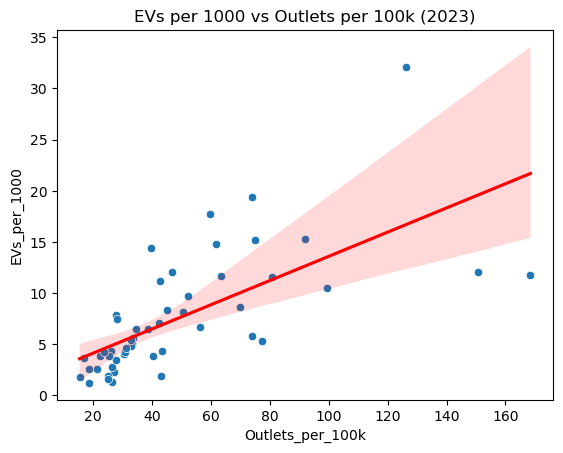

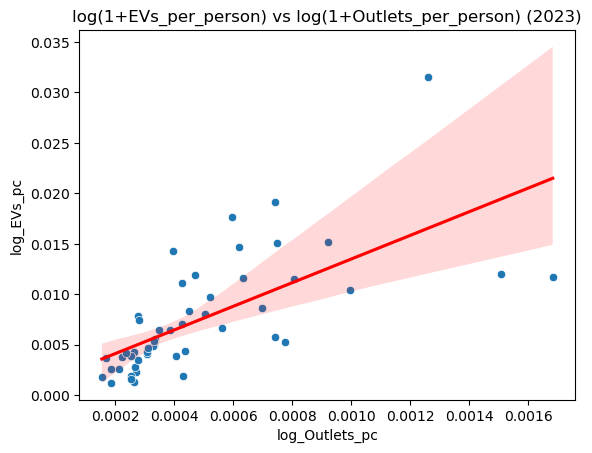

In [13]:
# --- Simple plots ---
plt.figure()
sns.scatterplot(x='Outlets_per_100k', y='EVs_per_1000', data=df_latest)
sns.regplot(x='Outlets_per_100k', y='EVs_per_1000', data=df_latest, scatter=False, ci=95, line_kws={'color':'red'})
plt.title(f'EVs per 1000 vs Outlets per 100k ({latest_year})')
plt.show()

# Log-log scatter
plt.figure()
sns.scatterplot(x='log_Outlets_pc', y='log_EVs_pc', data=df_latest)
sns.regplot(x='log_Outlets_pc', y='log_EVs_pc', data=df_latest, scatter=False, ci=95, line_kws={'color':'red'})
plt.title(f'log(1+EVs_per_person) vs log(1+Outlets_per_person) ({latest_year})')
plt.show()

### State-year comparative analysis

In [14]:
# State-year comparative analysis: rankings, growth, small-multiples, quartiles, and heatmaps

# Expect `merged` to exist from previous cell with columns: State, Year, Charging_Outlets, Registrations, Population, Outlets_per_100k, EVs_per_1000

# 1) Top and bottom states by EVs per 1000 in latest year
latest_year = merged['Year'].max()
df_latest = merged[merged['Year']==latest_year].copy()
ranked = df_latest.sort_values('EVs_per_1000', ascending=False)
print('\nTop 10 states by EVs per 1000 (latest year):')
print(ranked[['State','EVs_per_1000','Outlets_per_100k']].head(10).to_string(index=False))
print('\nBottom 10 states by EVs per 1000 (latest year):')
print(ranked[['State','EVs_per_1000','Outlets_per_100k']].tail(10).to_string(index=False))

# 2) Growth rates 2026 -> latest_year for EVs per 1000 and Outlets per 100k
start_year = 2016
end_year = latest_year
pivot = merged.pivot(index='State', columns='Year', values='EVs_per_1000')
if start_year in pivot.columns and end_year in pivot.columns:
    pivot['EV_growth_pct'] = (pivot[end_year] - pivot[start_year]) / pivot[start_year].replace({0: np.nan}) * 100
else:
    pivot['EV_growth_pct'] = np.nan

pivot_out = merged.pivot(index='State', columns='Year', values='Outlets_per_100k')
if start_year in pivot_out.columns and end_year in pivot_out.columns:
    pivot_out['Outlets_growth_pct'] = (pivot_out[end_year] - pivot_out[start_year]) / pivot_out[start_year].replace({0: np.nan}) * 100
else:
    pivot_out['Outlets_growth_pct'] = np.nan

growth = pd.DataFrame({
    'EV_growth_pct': pivot['EV_growth_pct'],
    'Outlets_growth_pct': pivot_out['Outlets_growth_pct']
}).reset_index()
print('\nTop 10 EV growth 2016->{}:'.format(end_year))
print(growth.sort_values('EV_growth_pct', ascending=False).head(10).to_string(index=False))




Top 10 states by EVs per 1000 (latest year):
               State  EVs_per_1000  Outlets_per_100k
          California     32.057191        126.108797
          Washington     19.357745         74.032876
              Hawaii     17.760671         59.664753
            Colorado     15.267721         92.046907
              Oregon     15.139928         74.994364
              Nevada     14.746312         61.816291
          New Jersey     14.371551         39.692346
             Vermont     12.023900        150.761205
             Arizona     12.016550         46.915393
District of Columbia     11.784835        168.479494

Bottom 10 states by EVs per 1000 (latest year):
        State  EVs_per_1000  Outlets_per_100k
         Iowa      2.796408         26.565880
     Kentucky      2.549117         18.656901
      Alabama      2.540217         21.415983
     Arkansas      2.313108         27.138297
      Wyoming      1.880127         43.071990
 South Dakota      1.851237         25.263937


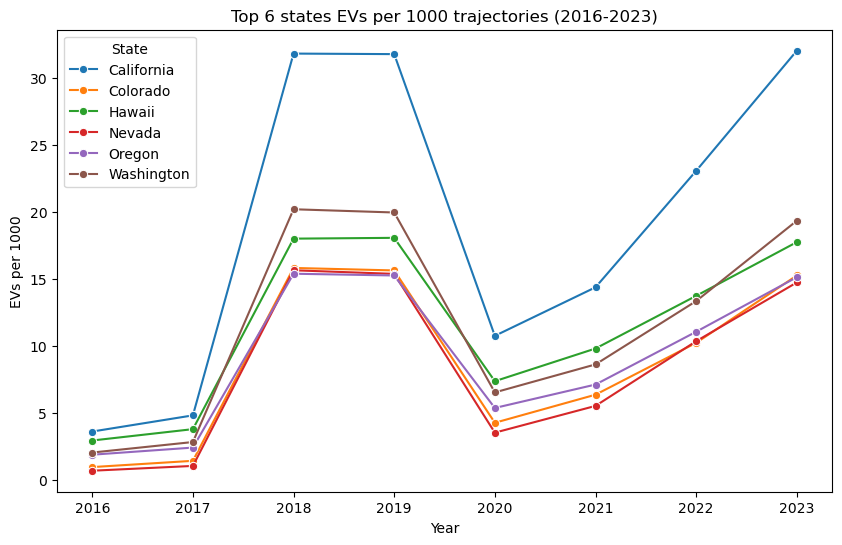

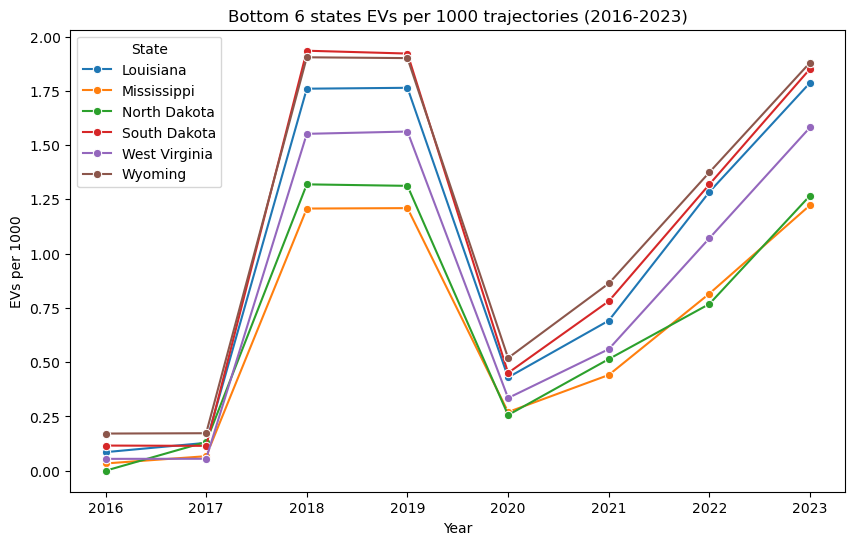

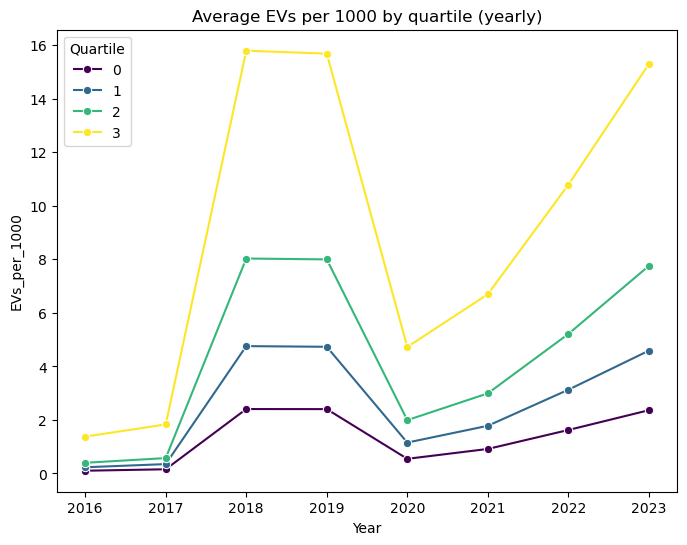


Yearly correlations:
       pearson  spearman
Year                    
2016  0.603526  0.744163
2017  0.658030  0.688416
2018  0.648475  0.704796
2019  0.648636  0.754027
2020  0.665256  0.809231
2021  0.696174  0.802534
2022  0.668609  0.798914
2023  0.671395  0.821448


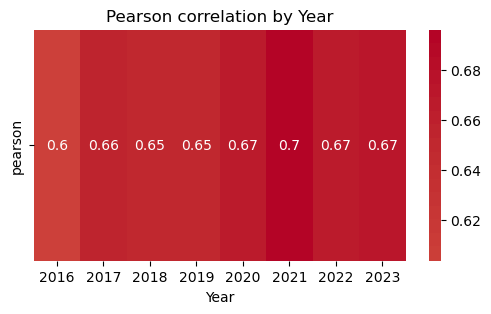

In [15]:
# 3) Small multiples: trajectories for top 6 and bottom 6 states by EVs per 1000
top_states = ranked['State'].head(6).tolist()
bottom_states = ranked['State'].tail(6).tolist()

def plot_trajectories(states, title):
    df = merged[merged['State'].isin(states)].copy()
    plt.figure(figsize=(10,6))
    sns.lineplot(data=df, x='Year', y='EVs_per_1000', hue='State', marker='o')
    ax = plt.gca()
    # force integer ticks for years
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    years = sorted(df['Year'].unique())
    ax.set_xticks(years)
    ax.set_xticklabels([int(y) for y in years])
    plt.title(title)
    plt.ylabel('EVs per 1000')
    plt.show()

plot_trajectories(top_states, f'Top 6 states EVs per 1000 trajectories (2016-{latest_year})')
plot_trajectories(bottom_states, f'Bottom 6 states EVs per 1000 trajectories (2016-{latest_year})')

# 4) Quartile-average trajectories
merged['EV_quartile'] = merged.groupby('Year')['EVs_per_1000'].transform(lambda x: pd.qcut(x, 4, labels=False, duplicates='drop'))
quartile_avg = merged.groupby(['Year','EV_quartile'])['EVs_per_1000'].mean().reset_index()
plt.figure(figsize=(8,6))
sns.lineplot(data=quartile_avg, x='Year', y='EVs_per_1000', hue='EV_quartile', palette='viridis', marker='o')
ax = plt.gca()
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
years = sorted(quartile_avg['Year'].unique())
ax.set_xticks(years)
ax.set_xticklabels([int(y) for y in years])
plt.title('Average EVs per 1000 by quartile (yearly)')
plt.legend(title='Quartile')
plt.show()

# 5) Year-by-year correlation heatmap between Outlets_per_100k and EVs_per_1000
corrs = merged.groupby('Year').apply(lambda g: pd.Series({
    'pearson': g['Outlets_per_100k'].corr(g['EVs_per_1000'], method='pearson'),
    'spearman': g['Outlets_per_100k'].corr(g['EVs_per_1000'], method='spearman')
}))
print('\nYearly correlations:')
print(corrs)

plt.figure(figsize=(6,3))
sns.heatmap(corrs[['pearson']].T, annot=True, cmap='coolwarm', center=0)
plt.title('Pearson correlation by Year')
plt.show()


In [16]:
# 6) States where outlets grew faster than EV adoption (potential overbuild) and vice versa
growth_filtered = growth.dropna()
growth_filtered['diff'] = growth_filtered['Outlets_growth_pct'] - growth_filtered['EV_growth_pct']
print('\nStates where Outlets grew faster than EVs (largest positive difference):')
print(growth_filtered.sort_values('diff', ascending=False).head(10).to_string(index=False))
print('\nStates where EVs grew faster than Outlets (largest negative difference):')
print(growth_filtered.sort_values('diff', ascending=True).head(10).to_string(index=False))


States where Outlets grew faster than EVs (largest positive difference):
               State  EV_growth_pct  Outlets_growth_pct        diff
              Alaska    1259.065865         2396.654329 1137.588465
             Georgia     377.955265          211.441523 -166.513742
              Hawaii     503.676320           50.485788 -453.190532
          California     787.341175          261.722299 -525.618876
              Oregon     704.181065          145.576579 -558.604486
           Wisconsin     832.213134          205.799224 -626.413910
          Washington     847.720266          201.537063 -646.183204
             Wyoming     998.398132          299.417503 -698.980630
                Utah    1313.498404          563.336343 -750.162061
District of Columbia    1247.036114          379.443006 -867.593108

States where EVs grew faster than Outlets (largest negative difference):
         State  EV_growth_pct  Outlets_growth_pct         diff
      Michigan    3002.350803          19

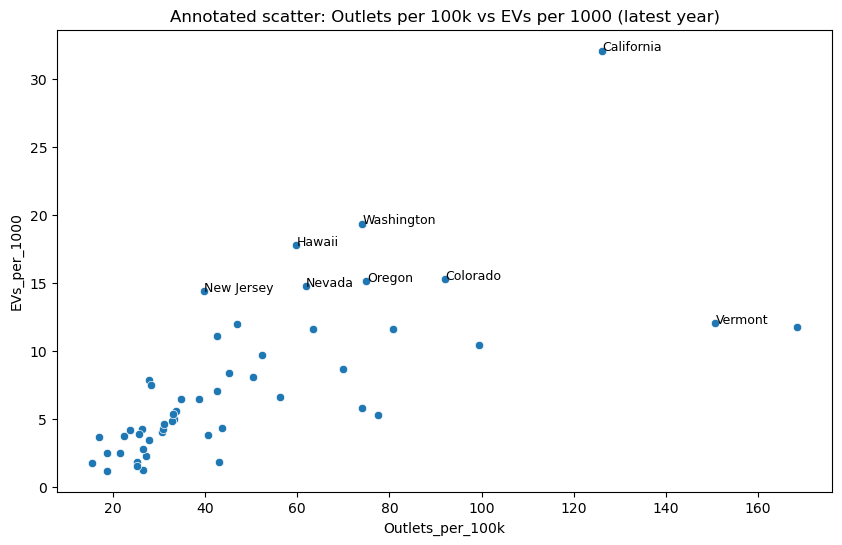

In [17]:
# 7) Scatter annotated for latest year: label a few interesting states
plt.figure(figsize=(10,6))
sns.scatterplot(data=df_latest, x='Outlets_per_100k', y='EVs_per_1000')
for i, row in df_latest.sort_values('EVs_per_1000', ascending=False).head(8).iterrows():
    plt.text(row['Outlets_per_100k']+0.1, row['EVs_per_1000']+0.01, row['State'], fontsize=9)
plt.title('Annotated scatter: Outlets per 100k vs EVs per 1000 (latest year)')
plt.show()

### Prediction

In [18]:
# Forecasting EV adoption: panel regression + per-state ARIMA (where possible)
# Requires: merged DataFrame with State, Year, EVs_per_1000, Outlets_per_100k

# --- 1) Simple panel regression forecast (pooled) ---
# Fit EVs_per_1000 on Outlets_per_100k and a linear time trend, with state fixed effects
merged['Year_trend'] = merged['Year'] - merged['Year'].min()
panel_formula = 'EVs_per_1000 ~ Outlets_per_100k + Year_trend + C(State)'
panel_model = smf.ols(panel_formula, data=merged).fit(cov_type='cluster', cov_kwds={'groups': merged['State']})
print('Panel regression summary:')
print(panel_model.summary())

# Forecasting with panel model for 5 years ahead under two scenarios for outlets growth
last_year = merged['Year'].max()
forecast_years = list(range(last_year+1, last_year+6))

# Create baseline scenario: outlets grow at same average pct observed 2016->last_year per state
pct_outlet_growth = (merged[merged['Year']==last_year].set_index('State')['Outlets_per_100k'] - merged[merged['Year']==2016].set_index('State')['Outlets_per_100k']) / merged[merged['Year']==2016].set_index('State')['Outlets_per_100k']
avg_pct_growth = pct_outlet_growth.replace([np.inf, -np.inf], np.nan).dropna().mean()

# Scenario 1: baseline growth continues (compounded)
state_base = merged[merged['Year']==last_year].set_index('State')[['Outlets_per_100k','EVs_per_1000']]

forecast_rows = []
for state, row in state_base.iterrows():
    outlets0 = row['Outlets_per_100k']
    ev0 = row['EVs_per_1000']
    for i, y in enumerate(forecast_years, start=1):
        outlets_proj = outlets0 * ((1 + avg_pct_growth) ** i)
        year_trend = y - merged['Year'].min()
        # prepare data for prediction (need state dummies)
        pred_df = pd.DataFrame({
            'Outlets_per_100k': [outlets_proj],
            'Year_trend': [year_trend],
            'State': [state]
        })
        pred = panel_model.predict(pred_df)[0]
        forecast_rows.append({'State': state, 'Year': y, 'EVs_per_1000_forecast_panel_baseline': pred, 'Outlets_per_100k_proj': outlets_proj})

forecast_panel = pd.DataFrame(forecast_rows)
print('\nPanel-model forecasts (baseline scenario) - sample:')
print(forecast_panel.groupby('Year')['EVs_per_1000_forecast_panel_baseline'].mean())

# Scenario 2: accelerated outlets rollout (+10% relative growth)
acc = 0.10
forecast_rows_acc = []
for state, row in state_base.iterrows():
    outlets0 = row['Outlets_per_100k']
    for i, y in enumerate(forecast_years, start=1):
        outlets_proj = outlets0 * ((1 + avg_pct_growth + acc) ** i)
        year_trend = y - merged['Year'].min()
        pred_df = pd.DataFrame({'Outlets_per_100k': [outlets_proj], 'Year_trend': [year_trend], 'State': [state]})
        pred = panel_model.predict(pred_df)[0]
        forecast_rows_acc.append({'State': state, 'Year': y, 'EVs_per_1000_forecast_panel_acc': pred, 'Outlets_per_100k_proj': outlets_proj})

forecast_panel_acc = pd.DataFrame(forecast_rows_acc)
print('\nPanel-model forecasts (accelerated outlets) - sample:')
print(forecast_panel_acc.groupby('Year')['EVs_per_1000_forecast_panel_acc'].mean())

# --- 2) Per-state ARIMA time-series forecasts (only for states with >=3 data points) ---
arima_forecasts = []
for state, g in merged.groupby('State'):
    g_sorted = g.sort_values('Year')
    if len(g_sorted) >= 3:
        ts = g_sorted.set_index('Year')['EVs_per_1000']
        try:
            model = ARIMA(ts, order=(1,1,0)).fit()
            fc = model.get_forecast(steps=5)
            mean_fc = fc.predicted_mean
            for i, y in enumerate(forecast_years):
                arima_forecasts.append({'State': state, 'Year': y, 'EVs_per_1000_arima': float(mean_fc.iloc[i])})
        except Exception:
            continue

arima_df = pd.DataFrame(arima_forecasts)
print('\nARIMA forecast sample (mean across states):')
if not arima_df.empty:
    print(arima_df.groupby('Year')['EVs_per_1000_arima'].mean())
else:
    print('Not enough data for ARIMA forecasts.')

# --- Save forecasts to CSVs for inspection ---
forecast_panel.to_csv('forecast_panel_baseline.csv', index=False)
forecast_panel_acc.to_csv('forecast_panel_accelerated.csv', index=False)
arima_df.to_csv('forecast_arima.csv', index=False)

print('\nForecast CSVs saved: forecast_panel_baseline.csv, forecast_panel_accelerated.csv, forecast_arima.csv')

# Notes for interpretation: use panel_model params for elasticity estimate; compare panel vs ARIMA to see structural differences.



Panel regression summary:
                            OLS Regression Results                            
Dep. Variable:           EVs_per_1000   R-squared:                       0.562
Model:                            OLS   Adj. R-squared:                  0.498
Method:                 Least Squares   F-statistic:                     15.31
Date:                Thu, 11 Dec 2025   Prob (F-statistic):           6.50e-06
Time:                        10:30:29   Log-Likelihood:                -1063.5
No. Observations:                 408   AIC:                             2233.
Df Residuals:                     355   BIC:                             2446.
Df Model:                          52                                         
Covariance Type:              cluster                                         
                                       coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------

The panel model shows signs of severe overfitting, with only 7.8 observations per parameter (well below the recommended 10-20 threshold). This is confirmed by explosive out-of-sample forecasts (predicting 7,393 EVs per 1,000 people by 2028—physically impossible), suspiciously small standard errors for some state coefficients (SE < 0.002), and a high condition number (2,020) indicating multicollinearity among the 50 state dummy variables. While the model's R²=0.562 appears reasonable, this goodness-of-fit is largely artificial, driven by overfitting to state-specific patterns rather than generalizable relationships.

Gas Price Data Set

Data Cleaning

In [19]:
# pip install openpyxl

In [20]:
gas_prices_path = 'DSC190/Datasets/10641_gasoline_prices_by_year_1-26-24.xlsx'

In [21]:
gas_prices = pd.read_excel(gas_prices_path, skiprows=1)

In [22]:
gas_prices.columns = gas_prices.iloc[0]
gas_prices = gas_prices.drop(index=0).reset_index(drop=True)

In [23]:
gas_prices = gas_prices.dropna(axis=1, how='all')
gas_prices["year"] = pd.to_numeric(gas_prices["Year"], errors="coerce")
gas_prices["Gasoline Price ($/gallon)"] = pd.to_numeric(gas_prices["Gasoline Price ($/gallon)"], errors="coerce")
gas_prices["Gasoline Price (2023 $/gallon)"] = pd.to_numeric(gas_prices["Gasoline Price (2023 $/gallon)"], errors="coerce")
# Drop the duplicate 'year' column (keep 'Year')
gas_prices = gas_prices.drop('year', axis=1)

# Remove rows where Year is not numeric (the footer text)
gas_prices = gas_prices[gas_prices['Year'].apply(lambda x: str(x).replace('.','').isdigit())]

# Convert Year to integer
gas_prices['Year'] = gas_prices['Year'].astype(int)


# Reset the index
gas_prices = gas_prices.reset_index(drop=True)

gas_prices.head()



,Year,Gasoline Price ($/gallon),Inflation Adjuster,Gasoline Price (2023 $/gallon)
0,1950,0.268,12.28,3.29104
1,1951,0.272,11.59,3.15248
2,1952,0.274,11.5,3.15100
3,1953,0.287,11.41,3.27467
4,1954,0.290,11.5,3.33500


In [24]:
gas_prices.columns

Index(['Year', 'Gasoline Price ($/gallon)', 'Inflation Adjuster',
       'Gasoline Price (2023 $/gallon)'],
      dtype='object', name=0)

In [25]:
# Change object type to float
gas_prices['Inflation Adjuster'] = gas_prices['Inflation Adjuster'].astype(float)

In [26]:
merged

,State,Charging_Outlets,Year,Registrations,Population,Outlets_per_100k,EVs_per_1000,log_Outlets_pc,log_EVs_pc,EV_quartile,Year_trend
0,Alabama,227,2016,500,4863525.0,4.667397,0.102806,0.000047,0.000103,0,0
1,Alaska,5,2016,200,741456.0,0.674349,0.269740,0.000007,0.000270,1,0
2,Arizona,988,2016,4700,6941072.0,14.234113,0.677129,0.000142,0.000677,3,0
3,Arkansas,89,2016,200,2989918.0,2.976670,0.066891,0.000030,0.000067,0,0
4,California,13655,2016,141500,39167117.0,34.863429,3.612724,0.000349,0.003606,3,0
...,...,...,...,...,...,...,...,...,...,...,...
403,Virginia,4565,2023,84900,8734685.0,52.262904,9.719870,0.000522,0.009673,2,7
404,Washington,5817,2023,152100,7857320.0,74.032876,19.357745,0.000740,0.019173,3,7
405,West Virginia,446,2023,2800,1770495.0,25.190695,1.581479,0.000252,0.001580,0,7
406,Wisconsin,1398,2023,24900,5930405.0,23.573432,4.198701,0.000236,0.004190,1,7


In [27]:
# Create a simplified DataFrame with just Year and Registrations (summed across all states)
registrations_by_year = merged.groupby('Year')['Registrations'].sum().reset_index()

# Merge with gas prices
registrations_gas = registrations_by_year.merge(gas_prices, on='Year', how='left')


In [28]:
registrations_gas

,Year,Registrations,Gasoline Price ($/gallon),Inflation Adjuster,Gasoline Price (2023 $/gallon)
0,2016,280300,2.142,1.27,2.72034
1,2017,377100,2.408,1.25,3.01000
2,2018,3555900,2.735,1.22,2.73500
3,2019,3555900,2.640,1.19,3.14160
4,2020,1018900,2.170,1.18,2.56060
5,2021,1454400,3.050,1.10,3.35500
6,2022,2442300,4.094,1.03,4.21682
7,2023,3555900,3.500,1.00,3.50000


In [29]:
print("\n" + "="*80)
print("1. DATASET OVERVIEW")
print("="*80)

print("\nDataset Shape:", registrations_gas.shape)
print("\nColumn Names and Types:")
print(registrations_gas.dtypes)
print("\nFirst Few Rows:")
print(registrations_gas.head())
print("\nDataset Info:")
print(registrations_gas.info())

# Check for missing values
print("\nMissing Values:")
print(registrations_gas.isnull().sum())

# Check for duplicates
print(f"\nDuplicate Rows: {registrations_gas.duplicated().sum()}")


1. DATASET OVERVIEW

Dataset Shape: (8, 5)

Column Names and Types:
Year                                int64
Registrations                       int64
Gasoline Price ($/gallon)         float64
Inflation Adjuster                float64
Gasoline Price (2023 $/gallon)    float64
dtype: object

First Few Rows:
   Year  Registrations  Gasoline Price ($/gallon)  Inflation Adjuster  \
0  2016         280300                      2.142                1.27   
1  2017         377100                      2.408                1.25   
2  2018        3555900                      2.735                1.22   
3  2019        3555900                      2.640                1.19   
4  2020        1018900                      2.170                1.18   

   Gasoline Price (2023 $/gallon)  
0                         2.72034  
1                         3.01000  
2                         2.73500  
3                         3.14160  
4                         2.56060  

Dataset Info:
<class 'pandas.core.

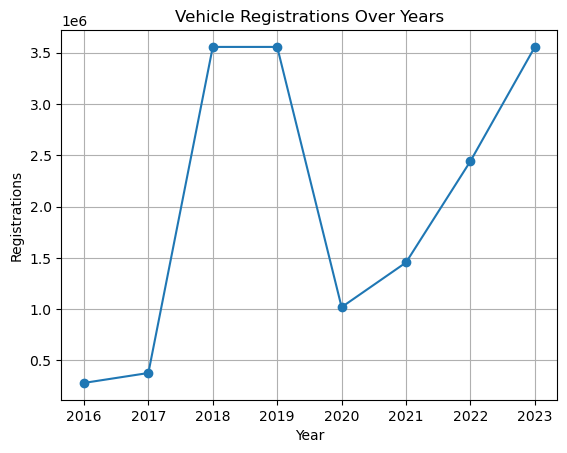

In [30]:
# Plot vechicle registrations over the years
plt.plot(registrations_gas['Year'], registrations_gas['Registrations'], marker='o')
plt.title('Vehicle Registrations Over Years')
plt.xlabel('Year')
plt.ylabel('Registrations')
plt.grid(True)
plt.show()


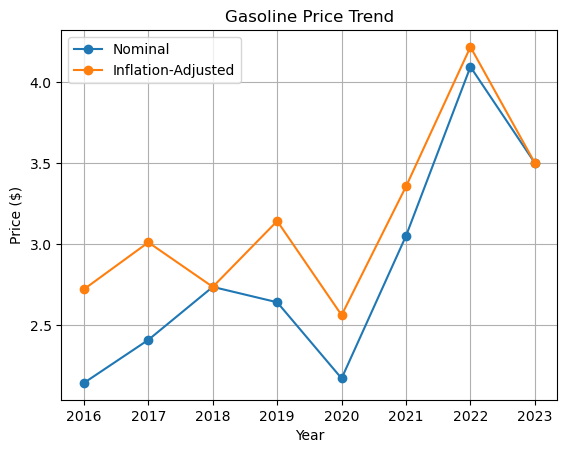

In [31]:
#Gasoline Price trend

plt.plot(registrations_gas['Year'], registrations_gas['Gasoline Price ($/gallon)'], marker='o', label='Nominal')
plt.plot(registrations_gas['Year'], registrations_gas['Gasoline Price (2023 $/gallon)'], marker='o', label='Inflation-Adjusted')
plt.title('Gasoline Price Trend')
plt.xlabel('Year')
plt.ylabel('Price ($)')
plt.legend()
plt.grid(True)
plt.show()


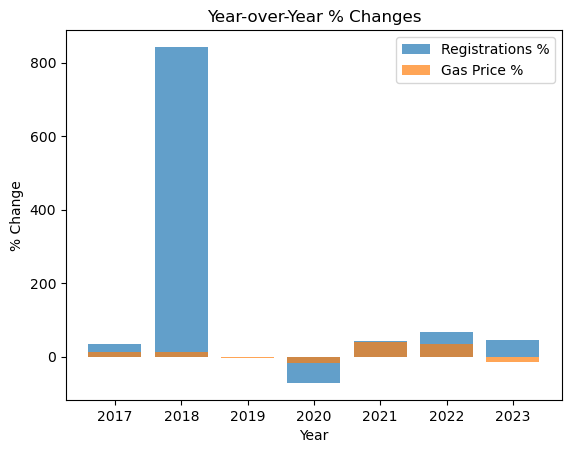

In [32]:
# Year over Year changes 

registrations_gas['Reg_YoY_Change'] = registrations_gas['Registrations'].diff()
registrations_gas['Reg_YoY_Pct'] = registrations_gas['Registrations'].pct_change() * 100
registrations_gas['GasPrice_YoY_Change'] = registrations_gas['Gasoline Price ($/gallon)'].diff()
registrations_gas['GasPrice_YoY_Pct'] = registrations_gas['Gasoline Price ($/gallon)'].pct_change() * 100

plt.bar(registrations_gas['Year'][1:], registrations_gas['Reg_YoY_Pct'][1:], alpha=0.7, label='Registrations %')
plt.bar(registrations_gas['Year'][1:], registrations_gas['GasPrice_YoY_Pct'][1:], alpha=0.7, label='Gas Price %')
plt.title('Year-over-Year % Changes')
plt.xlabel('Year')
plt.ylabel('% Change')
plt.legend()
plt.show()

#Easier Column names
registrations_gas.rename(columns={
    'Reg_YoY_Pct': 'RegPct',
    'GasPrice_YoY_Pct': 'GasPct'
}, inplace=True)



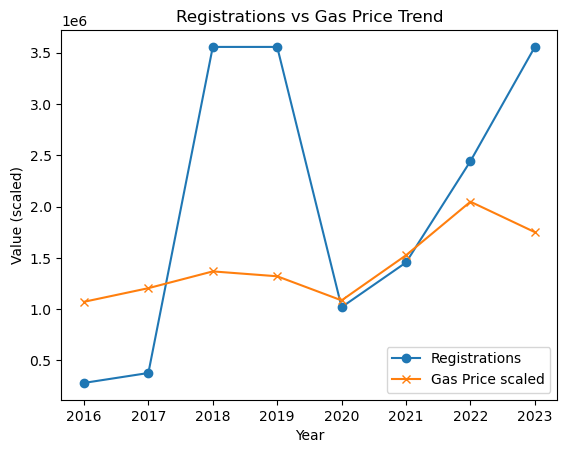

In [33]:
# Both trends
plt.plot(registrations_gas['Year'], registrations_gas['Registrations'], marker='o', label='Registrations')
plt.plot(registrations_gas['Year'], registrations_gas['Gasoline Price ($/gallon)']*500000, marker='x', label='Gas Price scaled')
plt.title('Registrations vs Gas Price Trend')
plt.xlabel('Year')
plt.ylabel('Value (scaled)')
plt.legend()
plt.show()


In [34]:
registrations_gas['Price_Difference'] = registrations_gas['Gasoline Price (2023 $/gallon)'] - registrations_gas['Gasoline Price ($/gallon)']

registrations_gas

,Year,Registrations,Gasoline Price ($/gallon),Inflation Adjuster,Gasoline Price (2023 $/gallon),Reg_YoY_Change,RegPct,GasPrice_YoY_Change,GasPct,Price_Difference
0,2016,280300,2.142,1.27,2.72034,NaN,NaN,NaN,NaN,0.57834
1,2017,377100,2.408,1.25,3.01000,96800.0,34.534427,0.266,12.418301,0.60200
2,2018,3555900,2.735,1.22,2.73500,3178800.0,842.959427,0.327,13.579734,0.00000
3,2019,3555900,2.640,1.19,3.14160,0.0,0.000000,-0.095,-3.473492,0.50160
4,2020,1018900,2.170,1.18,2.56060,-2537000.0,-71.346213,-0.470,-17.803030,0.39060
5,2021,1454400,3.050,1.10,3.35500,435500.0,42.742173,0.880,40.552995,0.30500
6,2022,2442300,4.094,1.03,4.21682,987900.0,67.924917,1.044,34.229508,0.12282
7,2023,3555900,3.500,1.00,3.50000,1113600.0,45.596364,-0.594,-14.509038,0.00000



CORRELATION MATRIX
                                Registrations  Gasoline Price ($/gallon)  \
Registrations                        1.000000                   0.522727   
Gasoline Price ($/gallon)            0.522727                   1.000000   
Gasoline Price (2023 $/gallon)       0.332312                   0.943509   
Reg_YoY_Change                       0.604426                   0.448145   
RegPct                               0.447871                  -0.023829   
GasPrice_YoY_Change                 -0.184626                   0.457400   
GasPct                              -0.190036                   0.452146   

                                Gasoline Price (2023 $/gallon)  \
Registrations                                         0.332312   
Gasoline Price ($/gallon)                             0.943509   
Gasoline Price (2023 $/gallon)                        1.000000   
Reg_YoY_Change                                        0.262803   
RegPct                                   

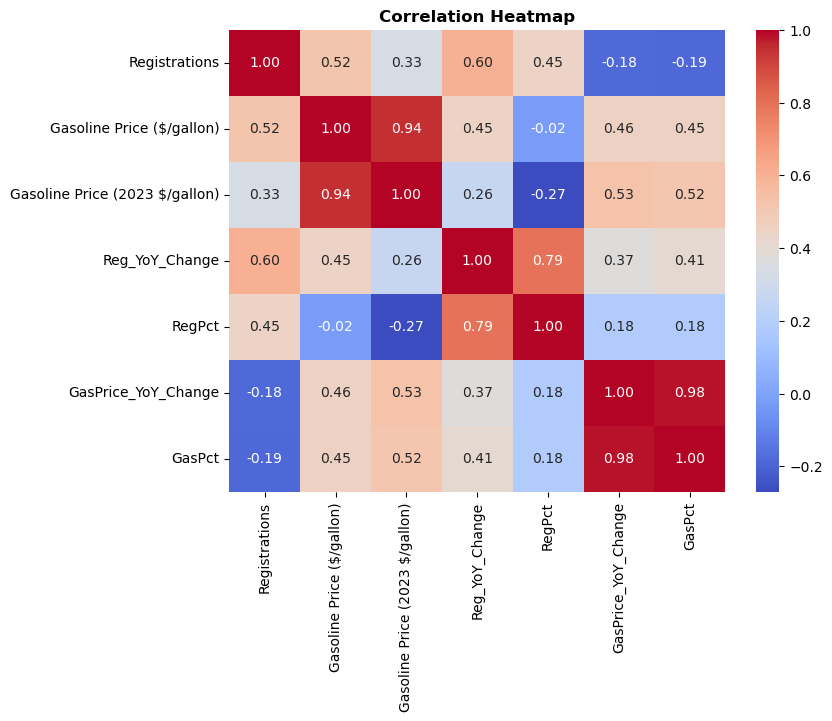

In [ ]:
#Correlation analysis
numeric_cols = ['Registrations', 'Gasoline Price ($/gallon)', 'Gasoline Price (2023 $/gallon)',
                'Reg_YoY_Change', 'RegPct', 'GasPrice_YoY_Change', 'GasPct']
corr = registrations_gas[numeric_cols].corr()

print("\n" + "="*80)
print("CORRELATION MATRIX")
print("="*80)
print(corr)

# Heatmap
plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap", fontweight='bold')
plt.show()

Strong Positive Relationships:

Registrations & Gas Prices (0.52): A moderate-to-strong positive correlation suggests that vehicle registrations have historically increased alongside gasoline prices. This is counterintuitive at first glance, but likely reflects a shared upward trend over time rather than a causal relationship where higher gas prices drive more registrations.
Nominal vs. Real Gas Prices (0.94): The near-perfect correlation between nominal and inflation-adjusted gas prices indicates prices have generally moved together, with inflation being relatively stable over the period analyzed.
Year-over-year changes (0.98): Gas price percentage changes and absolute YoY changes are nearly identical, as expected mathematically.

Moderate Positive Relationships:

Registrations & Registration YoY Change (0.60): Higher absolute registration levels correlate with larger year-over-year increases, suggesting growth has accelerated during periods of higher registration volume.
Registration changes & Gas price changes (0.37-0.45): There's a modest positive correlation between changes in both variables, indicating they may respond to similar economic conditions.

Weak/Negative Relationships:

RegPct & Real Gas Prices (-0.27): Percentage changes in registrations show a slight negative correlation with inflation-adjusted gas prices, hinting that when gas becomes more expensive in real terms, registration growth rates may slow somewhat.
Registrations & Gas Price Changes (-0.18 to -0.19): Slight negative correlations suggest that rapid gas price increases coincide with periods of slower absolute registration growth.


STATE-LEVEL EV ADOPTION REGRESSION RESULTS
                            OLS Regression Results                            
Dep. Variable:        log_EV_per_1000   R-squared:                       0.400
Model:                            OLS   Adj. R-squared:                  0.397
Method:                 Least Squares   F-statistic:                     134.8
Date:                Thu, 11 Dec 2025   Prob (F-statistic):           1.31e-45
Time:                        11:03:00   Log-Likelihood:                -394.37
No. Observations:                 408   AIC:                             794.7
Df Residuals:                     405   BIC:                             806.8
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------

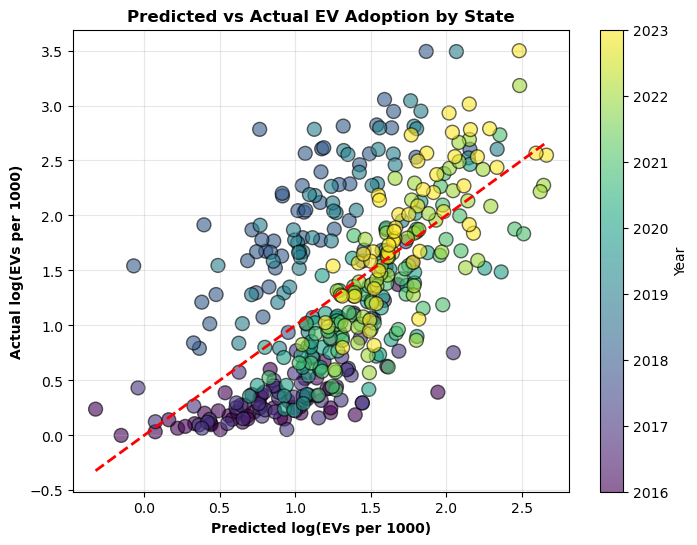

<function matplotlib.pyplot.show(close=None, block=None)>

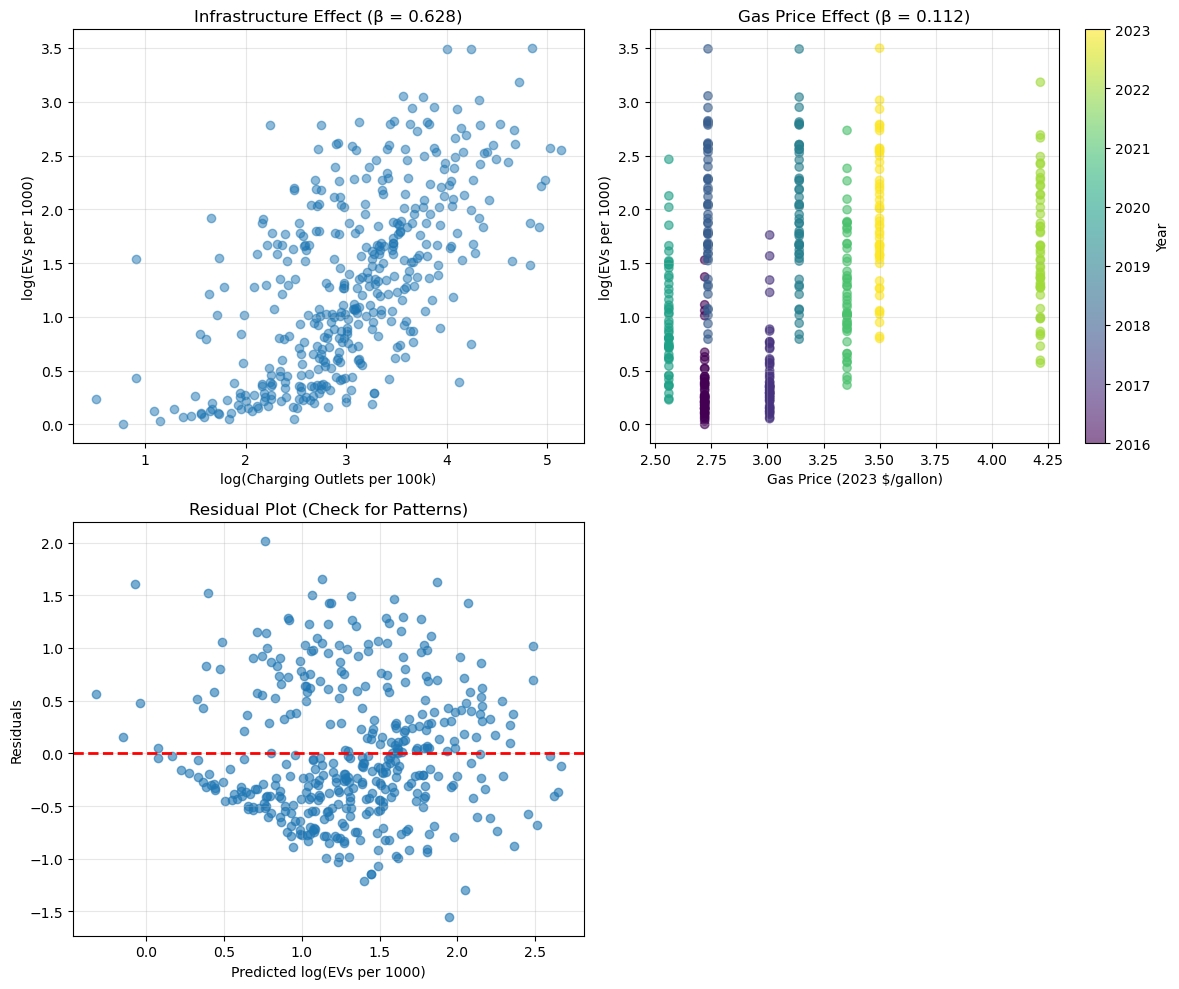

In [39]:
# Merge datasets
# ---------------------------
# registration_gas (national-level)
# merged (state-level)
merged_reg = merged.merge(
    registrations_gas[['Year', 'Gasoline Price (2023 $/gallon)', 'RegPct']],
    on='Year',
    how='left'
)

# Log-transform skewed variables
merged_reg['log_EV_per_1000'] = np.log1p(merged_reg['EVs_per_1000'])
merged_reg['log_Outlets_pc'] = np.log1p(merged_reg['Outlets_per_100k'])

# Define predictors and target
X = merged_reg[['log_Outlets_pc', 'Gasoline Price (2023 $/gallon)']]
y = merged_reg['log_EV_per_1000']

# Add constant term for intercept
X_const = sm.add_constant(X)

# Fit OLS regression
model = sm.OLS(y, X_const).fit()
print("\n" + "="*80)
print("STATE-LEVEL EV ADOPTION REGRESSION RESULTS")
print("="*80)
print(model.summary())

# Predicted vs Actual Plot
merged_reg['predicted_EV'] = model.predict(X_const)
plt.figure(figsize=(8,6))
scatter = plt.scatter(merged_reg['predicted_EV'], merged_reg['log_EV_per_1000'], 
                      alpha=0.6, edgecolors='black', c=merged_reg['Year'], cmap='viridis', s=100)
plt.plot([merged_reg['predicted_EV'].min(), merged_reg['predicted_EV'].max()],
         [merged_reg['predicted_EV'].min(), merged_reg['predicted_EV'].max()],
         'r--', linewidth=2)
plt.xlabel('Predicted log(EVs per 1000)', fontweight='bold')
plt.ylabel('Actual log(EVs per 1000)', fontweight='bold')
plt.title('Predicted vs Actual EV Adoption by State', fontweight='bold')
plt.colorbar(scatter, label='Year')
plt.grid(alpha=0.3)
plt.show()

# Additional subplots: Infrastructure and Gas Price effects, residuals
fig, axes = plt.subplots(2, 2, figsize=(12,10))

# Plot 2: Infrastructure effect
ax2 = axes[0, 0]
ax2.scatter(merged_reg['log_Outlets_pc'], merged_reg['log_EV_per_1000'], alpha=0.5)
ax2.set_xlabel('log(Charging Outlets per 100k)')
ax2.set_ylabel('log(EVs per 1000)')
ax2.set_title(f'Infrastructure Effect (β = {model.params["log_Outlets_pc"]:.3f})')
ax2.grid(True, alpha=0.3)

# Plot 3: Gas price effect
ax3 = axes[0, 1]
scatter2 = ax3.scatter(merged_reg['Gasoline Price (2023 $/gallon)'], 
                       merged_reg['log_EV_per_1000'], 
                       c=merged_reg['Year'], cmap='viridis', alpha=0.6)
ax3.set_xlabel('Gas Price (2023 $/gallon)')
ax3.set_ylabel('log(EVs per 1000)')
ax3.set_title(f'Gas Price Effect (β = {model.params["Gasoline Price (2023 $/gallon)"]:.3f})')
plt.colorbar(scatter2, ax=ax3, label='Year')
ax3.grid(True, alpha=0.3)

# Plot 4: Residual plot
ax4 = axes[1, 0]
residuals = merged_reg['log_EV_per_1000'] - merged_reg['predicted_EV']
ax4.scatter(merged_reg['predicted_EV'], residuals, alpha=0.6)
ax4.axhline(y=0, color='r', linestyle='--', lw=2)
ax4.set_xlabel('Predicted log(EVs per 1000)')
ax4.set_ylabel('Residuals')
ax4.set_title('Residual Plot (Check for Patterns)')
ax4.grid(True, alpha=0.3)

# Hide unused subplot (axes[1,1])
axes[1, 1].axis('off')

plt.tight_layout()
plt.savefig('ev_regression_results.png', dpi=300, bbox_inches='tight')
plt.show

Interpretation of State-Level EV Adoption Regression
This regression examines what drives electric vehicle adoption rates across U.S. states, measured as EVs per 1,000 residents (log-transformed).
Model Performance
R-squared: 0.400 - The model explains 40% of the variation in EV adoption across states. This is reasonably strong for cross-sectional state-level data, though 60% of variation remains unexplained by these two variables alone.
F-statistic: 134.8 (p < 0.001) - The model is highly statistically significant overall.
Key Findings
1. Charging Infrastructure (log_Outlets_pc): 0.628*

Interpretation: A 1% increase in charging outlets per capita is associated with a 0.628% increase in EV adoption.
Significance: Highly significant (t = 14.4, p < 0.001) - this is by far the strongest predictor.
Impact: This is the dominant driver of EV adoption. States with better charging infrastructure see substantially higher EV ownership rates.

2. Gasoline Price (2023 $/gallon): 0.112

Interpretation: A $1 increase in real gas prices is associated with an 11.2% increase in EV adoption.
Significance: Marginally significant (p = 0.100) - right at the threshold of conventional significance.
Impact: Higher gas prices modestly encourage EV adoption, but the effect is relatively weak and not definitively established.

Important Caveats
Durbin-Watson: 0.684 - This low value (far below 2.0) indicates strong positive serial correlation, likely because the data includes multiple time periods per state. This violates OLS assumptions and means:

Standard errors may be understated
Statistical significance may be overstated
A panel data model with state and time fixed effects would be more appropriate

Skewness & Kurtosis - The residuals show some non-normality (Jarque-Bera test rejects normality), suggesting the model may benefit from additional controls or transformation.
Bottom Line
Charging infrastructure availability is the critical factor driving state-level EV adoption - its effect is strong, clear, and statistically robust. Gasoline prices show a positive but modest relationship that's only marginally significant. The findings suggest that "if you build it, they will come" - states that invest in charging infrastructure see substantially higher EV adoption, while gas price effects are secondary at best.
However, the model's limitations (serial correlation, missing variables explaining 60% of variation) suggest caution in drawing strong causal conclusions.

In [57]:
import numpy as np
from scipy.stats import pearsonr

def permutation_test_r(x, y, n_perm=10000, seed=None):
    """
    Permutation test for correlation coefficient.
    Tests if observed correlation is significantly different from zero.
    """
    rng = np.random.default_rng(seed)
    x = np.asarray(x)
    y = np.asarray(y)
    
    # Remove NaN pairs
    mask = ~(np.isnan(x) | np.isnan(y))
    x_clean = x[mask]
    y_clean = y[mask]
    
    obs_r, _ = pearsonr(x_clean, y_clean)
    count = 0
    
    for _ in range(n_perm):
        y_perm = rng.permutation(y_clean)
        r_perm, _ = pearsonr(x_clean, y_perm)
        # two-sided: count |r_perm| >= |obs_r|
        if abs(r_perm) >= abs(obs_r):
            count += 1
    
    p_value = (count + 1) / (n_perm + 1)  # add-1 rule for stability
    return obs_r, p_value, len(x_clean)

# Test your key correlations
print("PERMUTATION TEST RESULTS (n=10,000 permutations)")
print("="*70)

# Test 1: Registrations vs Gas Price
x1 = registrations_gas['Registrations'].values
y1 = registrations_gas['Gasoline Price ($/gallon)'].values
obs_r1, p1, n1 = permutation_test_r(x1, y1, n_perm=10000, seed=42)

print(f"\n1. Registrations vs Gasoline Price ($/gallon)")
print(f"   Sample size: {n1}")
print(f"   Observed r: {obs_r1:.3f}")
print(f"   Permutation p-value: {p1:.4f}")
print(f"   Significant at α=0.05: {'Yes' if p1 < 0.05 else 'No'}")

# Test 2: RegPct vs GasPct
x2 = registrations_gas['RegPct'].values
y2 = registrations_gas['GasPct'].values
obs_r2, p2, n2 = permutation_test_r(x2, y2, n_perm=10000, seed=42)

print(f"\n2. RegPct vs GasPct")
print(f"   Sample size: {n2}")
print(f"   Observed r: {obs_r2:.3f}")
print(f"   Permutation p-value: {p2:.4f}")
print(f"   Significant at α=0.05: {'Yes' if p2 < 0.05 else 'No'}")

# Test 3: Year-over-year changes
x3 = registrations_gas['Reg_YoY_Change'].values
y3 = registrations_gas['GasPrice_YoY_Change'].values
obs_r3, p3, n3 = permutation_test_r(x3, y3, n_perm=10000, seed=42)

print(f"\n3. Reg_YoY_Change vs GasPrice_YoY_Change")
print(f"   Sample size: {n3}")
print(f"   Observed r: {obs_r3:.3f}")
print(f"   Permutation p-value: {p3:.4f}")
print(f"   Significant at α=0.05: {'Yes' if p3 < 0.05 else 'No'}")

print("\n" + "="*70)
print("INTERPRETATION:")
print("Permutation p-value = probability of getting this correlation")
print("(or stronger) if there were truly NO relationship between variables")

PERMUTATION TEST RESULTS (n=10,000 permutations)

1. Registrations vs Gasoline Price ($/gallon)
   Sample size: 8
   Observed r: 0.523
   Permutation p-value: 0.1823
   Significant at α=0.05: No

2. RegPct vs GasPct
   Sample size: 7
   Observed r: 0.178
   Permutation p-value: 0.7059
   Significant at α=0.05: No

3. Reg_YoY_Change vs GasPrice_YoY_Change
   Sample size: 7
   Observed r: 0.370
   Permutation p-value: 0.4214
   Significant at α=0.05: No

INTERPRETATION:
Permutation p-value = probability of getting this correlation
(or stronger) if there were truly NO relationship between variables


In [58]:
# Show what you'd need for significance
print("\n" + "="*80)
print("SAMPLE SIZE REQUIREMENTS FOR SIGNIFICANCE")
print("="*80)

correlations = [0.523, 0.370, 0.178]
names = ['Registrations vs Gas Price', 'YoY Changes', 'RegPct vs GasPct']

for name, r in zip(names, correlations):
    # Approximate n needed for p<0.05 (rule of thumb: |r| > 2/sqrt(n))
    n_needed = int((2/abs(r))**2) if r != 0 else 999
    print(f"\n{name} (r={r:.3f})")
    print(f"  Current n: {8 if r == 0.523 else 7}")
    print(f"  Approximate n needed: {n_needed}")
    print(f"  Additional years needed: {n_needed - (8 if r == 0.523 else 7)}")


SAMPLE SIZE REQUIREMENTS FOR SIGNIFICANCE

Registrations vs Gas Price (r=0.523)
  Current n: 8
  Approximate n needed: 14
  Additional years needed: 6

YoY Changes (r=0.370)
  Current n: 7
  Approximate n needed: 29
  Additional years needed: 22

RegPct vs GasPct (r=0.178)
  Current n: 7
  Approximate n needed: 126
  Additional years needed: 119


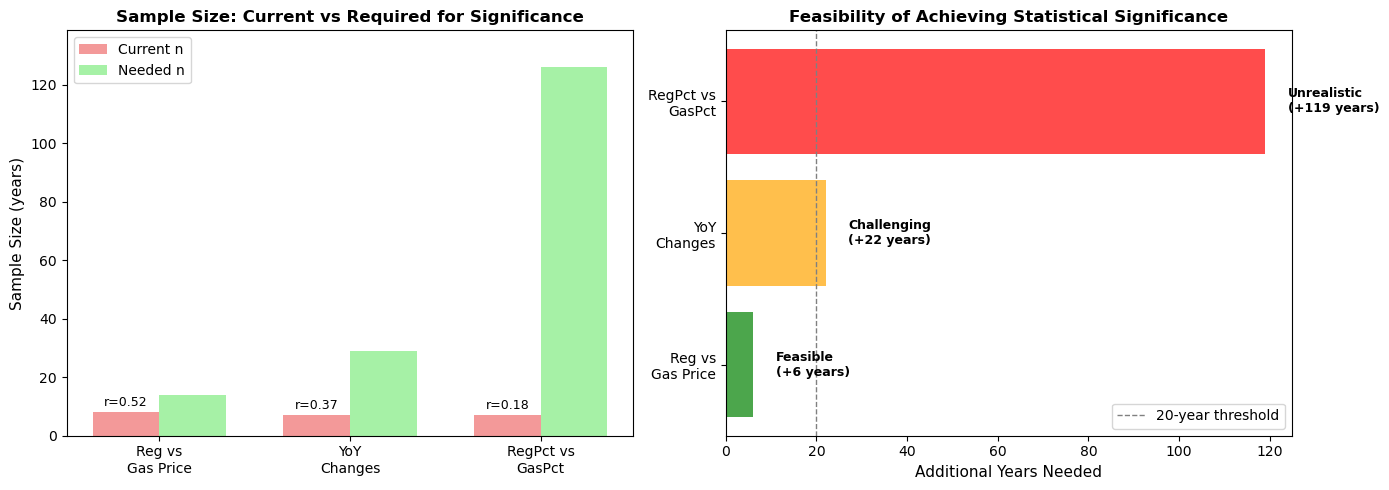

✓ Visualization saved as 'sample_size_analysis.png'


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Create visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Left plot: Current vs Needed Sample Size
relationships = ['Reg vs\nGas Price', 'YoY\nChanges', 'RegPct vs\nGasPct']
current_n = [8, 7, 7]
needed_n = [14, 29, 126]
correlations = [0.523, 0.370, 0.178]

x = np.arange(len(relationships))
width = 0.35

bars1 = ax1.bar(x - width/2, current_n, width, label='Current n', color='lightcoral', alpha=0.8)
bars2 = ax1.bar(x + width/2, needed_n, width, label='Needed n', color='lightgreen', alpha=0.8)

ax1.set_ylabel('Sample Size (years)', fontsize=11)
ax1.set_title('Sample Size: Current vs Required for Significance', fontsize=12, fontweight='bold')
ax1.set_xticks(x)
ax1.set_xticklabels(relationships)
ax1.legend()
ax1.set_ylim(0, max(needed_n) * 1.1)

# Add correlation values on bars
for i, (curr, need, corr) in enumerate(zip(current_n, needed_n, correlations)):
    ax1.text(i - width/2, curr + 2, f'r={corr:.2f}', ha='center', fontsize=9)

# Right plot: Feasibility assessment
feasibility_score = [6, 22, 119]  # years needed
colors_feasibility = ['green', 'orange', 'red']
labels_feasibility = ['Feasible\n(+6 years)', 'Challenging\n(+22 years)', 'Unrealistic\n(+119 years)']

bars3 = ax2.barh(relationships, feasibility_score, color=colors_feasibility, alpha=0.7)
ax2.set_xlabel('Additional Years Needed', fontsize=11)
ax2.set_title('Feasibility of Achieving Statistical Significance', fontsize=12, fontweight='bold')
ax2.axvline(x=20, color='gray', linestyle='--', linewidth=1, label='20-year threshold')
ax2.legend()

for i, (bar, label) in enumerate(zip(bars3, labels_feasibility)):
    width = bar.get_width()
    ax2.text(width + 5, bar.get_y() + bar.get_height()/2, 
             label, ha='left', va='center', fontsize=9, fontweight='bold')

plt.tight_layout()
plt.savefig('sample_size_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Visualization saved as 'sample_size_analysis.png'")

We examined correlations between vehicle registrations and gasoline prices using permutation testing (10,000 iterations), which is particularly appropriate for small samples as it makes no distributional assumptions. The strongest observed relationship was between total registrations and nominal gasoline prices (r=0.523, permutation p=0.182), followed by year-over-year changes in both variables (r=0.370, p=0.421). Percentage changes showed minimal correlation (r=0.178, p=0.706).

None of these correlations achieved statistical significance at α=0.05, reflecting insufficient statistical power from our limited temporal sample (n=7-8 annual observations, 2016-2023). Permutation testing confirms these p-values are not artifacts of distributional violations but genuine limitations of sample size. Power analysis indicates that detecting the observed r=0.523 correlation would require n=14 observations—just 6 additional years of data.

The data are consistent with either: (1) a moderate positive relationship between registrations and gas prices that is obscured by limited statistical power, or (2) no meaningful relationship. We cannot distinguish between these possibilities with 8 years of data. The observed correlation (r=0.523) suggests a potential relationship worth investigating with extended historical data, but should not be interpreted as evidence of a confirmed association.